In [1]:
#import of packages
import networkx as nx
import matplotlib.pyplot as plt
import random  
import numpy as np
import sys
from  fractions import Fraction
import timeit
from time import sleep
from collections import defaultdict
import heapq as heap
from tqdm import tqdm
from community import community_louvain
import collections 
import matplotlib.cm as cm
from IPython.display import HTML, display
from itertools import chain, combinations
from itertools import islice
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from joblib import Parallel, delayed
import csv
from pprint import pprint
import math
from operator import itemgetter

In [2]:
from IPython.core.magic import register_line_magic
from IPython.display import HTML, display
import json

@register_line_magic
def bg(color, cell=None):    
    script = (
        "var n = [this.closest('.cell,.jp-CodeCell')];"
        "n = n.concat([].slice.call(n[0].querySelectorAll('.input_area,.highlight,.jp-Editor')));"
        f"n.forEach(e=>e.style.background='{color}');"
        "this.parentNode.removeChild(this)"
    )
    display(HTML(f'<img src onerror="{script}" style="display:none">'))  

In [3]:
def set_weight_degree(G,p_n):
    for u,v in G.edges():
        G[u][v][p_n]= 1/G.in_degree(v)
    return G

def set_weight_trivalency(G,p_n):
    for u,v in G.edges():
        G[u][v][p_n]= random.choice([0.2,0.05,0.01])
    return G

def set_weight_value(G,val,p_n):
    for u,v in G.edges():
        G[u][v][p_n]= round(val,3)
    return G


In [4]:
def homophily_BA(n,r,d,h,alpha):
    g= nx.Graph()
    nx.set_node_attributes(g, [], "community")

    for i in tqdm(range(n),position=0, leave=True):
        g.add_node(i)
        if random.uniform(0, 1)<=r:
            g.nodes[i]['community']= 1
        else:
            g.nodes[i]['community']= 0
            
    for i in tqdm(range(n),position=0, leave=True):
        w_s=set()
        intra= round(d*h)
        inter=d-intra
        intra_community_nodes=[x for x in range(i) if g.nodes[i]['community']== g.nodes[x]['community']]
        inter_community_nodes=[x for x in range(i) if g.nodes[i]['community']!= g.nodes[x]['community']]
        if len(intra_community_nodes)>=intra and len(inter_community_nodes)>=inter:
            intra_weights=[g.degree(x)+1 for x in intra_community_nodes]
            while len(w_s)!=intra:
                choices=random.choices(intra_community_nodes,weights=intra_weights,k=1)
                w_s.update(choices)
                for j in set(choices): intra_weights[intra_community_nodes.index(j)]=0
                    
            intra_edges=w_s.copy()

            inter_weights=[g.degree(x)+1 for x in inter_community_nodes]
            while len(w_s)!=d:
                choices=random.choices(inter_community_nodes,weights=inter_weights,k=1)
                w_s.update(choices)
                for j in set(choices): inter_weights[inter_community_nodes.index(j)]=0
            #print(i,w_s)
            for w in w_s:
                g.add_edge(i,w)
            
    g=g.to_directed(as_view=False)                     
    return g

In [5]:
size=500 # number of iterations 
d=6
Homo_BA=homophily_BA(size,0.8,d,0.7,1)
print("Homo_BA")
print("nodes:"+str(len(Homo_BA.nodes()))+" edges:"+str(len(Homo_BA.edges())))
print("Average degree :"+str(sum([Homo_BA.out_degree(x) for x in Homo_BA.nodes()])/len(Homo_BA.nodes())))
print(sorted([Homo_BA.out_degree(x) for x in Homo_BA.nodes()],reverse=True)[0:10]) 

Random_Homo=homophily_BA(size,0.7,d,0.8,0)
print("Random_Homo")

BA=homophily_BA(size,0.7,d,0.5,1)
print("BA")


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 817.70it/s]


Homo_BA
nodes:500 edges:5892
Average degree :11.784
[218, 179, 75, 64, 55, 46, 46, 45, 44, 44]


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 694.47it/s]


Random_Homo


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 734.12it/s]

BA


In [34]:
def load_NetPhy(): # load coathorship dataset as graph2
    g=nx.read_edgelist("CA-HepPh.txt", nodetype=int,create_using=nx.Graph())
    g=nx.convert_node_labels_to_integers(g)
    partition=community_louvain.best_partition(g)
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
    return g

NetPhy=load_NetPhy() 
Gcc = sorted(nx.connected_components(NetPhy), key=len, reverse=True)
NetPhy = NetPhy.subgraph(Gcc[0])
NetPhy=nx.convert_node_labels_to_integers(NetPhy)
NetPhy=NetPhy.to_directed(as_view=False)
print("NetPhy")
d=collections.Counter([NetPhy.nodes[i]['community'] for i in NetPhy.nodes()])
#print(collections.OrderedDict(sorted(d.items())))

print("nodes:"+str(len(NetPhy.nodes()))+" edges:"+str(len(NetPhy.edges())))
print("Average degree :"+str(sum([NetPhy.out_degree(x) for x in NetPhy.nodes()])/len(NetPhy.nodes())))
print(sorted([NetPhy.out_degree(x) for x in NetPhy.nodes()],reverse=True)[0:10]) 
print("clustering coefficient: "+str(nx.average_clustering(NetPhy,NetPhy.nodes())))

NetPhy
nodes:11204 edges:235268
Average degree :20.998571938593358
[491, 486, 482, 444, 443, 440, 440, 425, 425, 424]
clustering coefficient: 0.6215823219256392


In [28]:
def load_NetTh(): # load coathorship dataset as graph2
    g=nx.read_edgelist("CA-HepTh.txt", nodetype=int,create_using=nx.Graph())
    g=nx.convert_node_labels_to_integers(g)
    partition=community_louvain.best_partition(g)
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
    return g


NetTh=load_NetTh() 
Gcc = sorted(nx.connected_components(NetTh), key=len, reverse=True)
NetTh = NetTh.subgraph(Gcc[0])
NetTh=nx.convert_node_labels_to_integers(NetTh)
NetTh=NetTh.to_directed(as_view=False)
print("NetTh")
d=collections.Counter([NetTh.nodes[i]['community'] for i in NetTh.nodes()])
#print(collections.OrderedDict(sorted(d.items())))

print("nodes:"+str(len(NetTh.nodes()))+" edges:"+str(len(NetTh.edges())))
print("Average degree :"+str(sum([NetTh.out_degree(x) for x in NetTh.nodes()])/len(NetTh.nodes())))
print(sorted([NetTh.out_degree(x) for x in NetTh.nodes()],reverse=True)[0:10]) 
print("clustering coefficient: "+str(nx.average_clustering(NetTh,NetTh.nodes())))

NetTh
nodes:8638 edges:49633
Average degree :5.7458902523732345
[65, 60, 59, 56, 54, 53, 53, 51, 51, 50]
clustering coefficient: 0.4815641520261662


In [6]:
def load_Facebook(): # load coathorship dataset as graph2
    g=nx.read_edgelist("facebook_combined.txt", nodetype=int,create_using=nx.Graph())
    g=nx.convert_node_labels_to_integers(g)
    partition=community_louvain.best_partition(g)
    g=g.to_directed(as_view=False)
    for node in g.nodes():
        g.nodes[node]['community']=partition[node]
    g=g.to_directed(as_view=False)
    return g
Facebook=load_Facebook() 
print("Facebook")
d=collections.Counter([Facebook.nodes[i]['community'] for i in Facebook.nodes()])
print(collections.OrderedDict(sorted(d.items())))

print("nodes:"+str(len(Facebook.nodes()))+" edges:"+str(len(Facebook.edges())))
print("Average degree :"+str(sum([Facebook.out_degree(x) for x in Facebook.nodes()])/len(Facebook.nodes())))
print(sorted([Facebook.out_degree(x) for x in Facebook.nodes()],reverse=True)[0:10])     
print("clustering coefficient: "+str(nx.average_clustering(Facebook,Facebook.nodes())))

Facebook
OrderedDict([(0, 350), (1, 432), (2, 435), (3, 423), (4, 535), (5, 323), (6, 128), (7, 19), (8, 548), (9, 73), (10, 237), (11, 25), (12, 60), (13, 206), (14, 19), (15, 226)])
nodes:4039 edges:176468
Average degree :43.69101262688784
[1045, 792, 755, 547, 347, 294, 291, 254, 245, 235]
clustering coefficient: 0.6055467186200876


In [85]:
def dijkstra_MIA(startingNode, G_path, G_deg,in_edges,min_prob,S_N,p_n): # dijkstra's algorithm to compute the MIIA
    
    MIA = nx.DiGraph()
    MIA.add_node(startingNode)

    prob,probabilities={startingNode: 1},{startingNode:1}
    steps,steps_final={startingNode:0},{startingNode:0}
    parentsMap={}
    
    pq = []
    nodeCosts = defaultdict(lambda: float('inf'))
    nodeCosts[startingNode] = 0
    heap.heappush(pq, (0, startingNode))
 
    while pq:
        # go greedily by always extending the shorter cost nodes first
        _, node = heap.heappop(pq)
        if node in S_N: continue
        if not in_edges:
            neighbors =list(G_path.successors(node))
        else:
            neighbors = list(G_path.predecessors(node))
        for adjNode in neighbors:  
            if not in_edges:    
                weight= -np.log(G_deg[node][adjNode][p_n])
                prob_val= round(G_deg[node][adjNode][p_n]*prob[node],3)
            else:
                weight= -np.log(G_deg[adjNode][node][p_n])
                prob_val= round(G_deg[adjNode][node][p_n]*prob[node],3)
            newCost = nodeCosts[node] + weight
            if nodeCosts[adjNode] > newCost and prob_val>=min_prob :
                parentsMap[adjNode]=node
                nodeCosts[adjNode] = newCost
                prob[adjNode]= prob_val
                steps[adjNode]=steps[node]+1
                heap.heappush(pq, (newCost, adjNode))
                
    for w in  parentsMap.keys() : 
        if  in_edges:
            MIA.add_edge(w,parentsMap[w])
        else:
            MIA.add_edge(parentsMap[w],w)
        probabilities[w]= prob[w]
        steps_final[w]= steps[w]
        
    return  MIA,steps_final,probabilities # we return the MIA and the parentMap in case we need to reconstruct the MIA

In [86]:
def dijkstra_MIOG(startingNode,G, min_prob,S_N): # dijkstra's algorithm to compute the MIOG
    
    MIOG = nx.DiGraph()
    MIOG.add_node(startingNode)
    
    prob,probabilities={startingNode: 1},{startingNode:1}
    steps,steps_final={startingNode:0},{startingNode:0}
    parentsMap={}
    
    pq = []
    nodeCosts = defaultdict(lambda: float('inf'))
    nodeCosts[startingNode] = 0
    heap.heappush(pq, (0, startingNode))
 
    while pq:
        # go greedily by always extending the shorter cost nodes first
        _, node = heap.heappop(pq)
        if node in S_N: continue
       
        neighbors =list(G.successors(node))
        for adjNode in neighbors:  
            
            weight= -np.log(G[node][adjNode]["negative"])
            prob_val= round(G[node][adjNode]["negative"]*prob[node],3)
    
            newCost = nodeCosts[node] + weight
            if nodeCosts[adjNode] > newCost and prob_val>=min_prob :
                parentsMap[adjNode]=[node]
                nodeCosts[adjNode] = newCost
                prob[adjNode]= prob_val
                steps[adjNode]=steps[node]+1
                heap.heappush(pq, (newCost, adjNode))
                continue 
            if nodeCosts[adjNode] == newCost and prob_val>=min_prob and adjNode!=startingNode and  node not in parentsMap[adjNode]  :
                parentsMap[adjNode]=parentsMap[adjNode]+[node]
                
    for w in  parentsMap.keys() : 
        for v in parentsMap[w]:
            MIOG.add_edge(v,w)
        probabilities[w]= prob[w]
        steps_final[w]= steps[w]  
    return  MIOG 

In [87]:
def get_p_value(v,pos,t,S_N,S_P):# initializes the values of P_p_t, P_n_t, ap_n_t and ap_p_t in compute_ap_N
    if v in S_P:
        if pos:
            if t==0: return 1,1 
            else: return 0,1
        else: return 0,0
            
    elif v in S_N:
        if pos: return 0,0
        else: 
            if t==0: return 1,1 
            else: 0,1
    else: return 0,0 

def compute_ap_N(u,S_N,S_P,MIA_n,MIA_p,G): #probability of transmission is inversly proportional to the in-degree  
    
    POS_t=[v for v in S_P if v in MIA_p.nodes() ]
    NEG_t=[v for v in S_N if v in MIA_n.nodes()]
    POS_next=set()
    NEG_next=set()
    
    P_p_t={}
    P_p_next={}
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    ap_p_t={}
    for node in list(MIA_n.nodes())+list(MIA_p.nodes()):
         
        P_p_t[node],ap_p_t[node] = get_p_value(node,True,0,S_N,S_P)
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,S_P)
    t=0
    
    while NEG_t:
        
        ap_n_next=ap_n_t.copy()
        ap_p_next=ap_p_t.copy()
        
        
        temp_P={k:1 for k in list(MIA_n.nodes())+list(MIA_p.nodes())}
        temp_N={k:1 for k in list(MIA_n.nodes())+list(MIA_p.nodes())}
        
        for v in POS_t: # positive influence has priority
            
            if not list(MIA_p.successors(v)):
                continue
            for w in list(MIA_p.successors(v)):
                POS_next.add(w)
                temp_P[w]*=(1-P_p_t[v]*G[v][w]['positive'])
            
        for v in POS_next:
            
            P_p_next[v]= (1-temp_P[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_p_next[v]=ap_p_t[v]+P_p_next[v]
             
        for v in NEG_t :
            if not list(MIA_n.successors(v)):
                continue 
            for w in list(MIA_n.successors(v)):
                NEG_next.add(w)
                temp_N[w]*=(1-P_n_t[v]*G[v][w]['negative'])
            
        for v in NEG_next: 
            P_n_next[v] = temp_P[v]*(1-temp_N[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v] 
            
        if list(POS_next): 
            ap_p_t = ap_p_next.copy()  
            
        if list(NEG_next):
            
            ap_n_t = ap_n_next.copy() 
          
            
        P_p_t,P_n_t,NEG_t,POS_t = P_p_next,P_n_next,NEG_next,POS_next
        POS_next=set()
        NEG_next=set()
        t+=1
    
    return ap_n_t[u]

In [88]:
def compute_ap_N_MIOG(S_N,S_P,MIOG_N,MIOG_P,G): #probability of transmission is inversly proportional to the in-degree  
    
    POS_t=[v for v in S_P if v in MIOG_P.nodes() ]
    NEG_t=[v for v in S_N if v in MIOG_N.nodes()]
    POS_next=set()
    NEG_next=set()
    
    P_p_t={}
    P_p_next={}
    P_n_t={}
    P_n_next={}
    
    ap_n_t={}
    ap_p_t={}
    for node in list(MIOG_N.nodes())+list(MIOG_P.nodes()):
         
        P_p_t[node],ap_p_t[node] = get_p_value(node,True,0,S_N,S_P)
        P_n_t[node],ap_n_t[node] = get_p_value(node,False,0,S_N,S_P)
    t=0
    
    while NEG_t:
        
        ap_n_next=ap_n_t.copy()
        ap_p_next=ap_p_t.copy()
        
        
        temp_P={k:1 for k in list(MIOG_N.nodes())+list(MIOG_P.nodes())}
        temp_N={k:1 for k in list(MIOG_N.nodes())+list(MIOG_P.nodes())}
        
        for v in POS_t: # positive influence has priority
            
            if not list(MIOG_P.successors(v)):
                continue
            for w in list(MIOG_P.successors(v)):
                POS_next.add(w)
                temp_P[w]*=(1-P_p_t[v]*G[v][w]['positive'])
            
        for v in POS_next:
            
            P_p_next[v]= (1-temp_P[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_p_next[v]=ap_p_t[v]+P_p_next[v]
             
        for v in NEG_t :
            if not list(MIOG_N.successors(v)):
                continue 
            for w in list(MIOG_N.successors(v)):
                NEG_next.add(w)
                temp_N[w]*=(1-P_n_t[v]*G[v][w]['negative'])
            
        for v in NEG_next: 
            P_n_next[v] = temp_P[v]*(1-temp_N[v])*(1-ap_n_t[v])*(1-ap_p_t[v])
            ap_n_next[v]=ap_n_t[v]+P_n_next[v] 
            
        if list(POS_next): 
            ap_p_t = ap_p_next.copy()  
            
        if list(NEG_next):
            
            ap_n_t = ap_n_next.copy() 
          
            
        P_p_t,P_n_t,NEG_t,POS_t = P_p_next,P_n_next,NEG_next,POS_next
        POS_next=set()
        NEG_next=set()
        t+=1
    
    return ap_n_t




In [89]:
def get_communities(part,G): # returns the number of communities in G given the partition part
    communities = []
    for i in G.nodes():
        if part[i] not in communities:
            communities.append(part[i])
    return len(communities)

def path_blocked_MIA(from_node,to_node, MIIA, S): # if a negative information needs to go through a node in S_P the path is blocked
    start=timeit.default_timer()
    current_node=from_node
    if current_node in S:
        return True
    while current_node != to_node and list(MIIA.successors(current_node)):
        if list(MIIA.successors(current_node))[0] in S:
            return True
        else:
            current_node=list(MIIA.successors(current_node))[0]
    return False

def path_blocked_MOA(from_node,to_node, MIOA, S): # if a negative information needs to go through a node in S_P the path is blocked
    current_node=to_node
    if current_node in S:
        return True
    while current_node != from_node:
        if list(MIOA.predecessors(current_node))[0] in S:
            return True
        else:
            current_node=list(MIOA.predecessors(current_node))[0] 
    return False

In [90]:
def CMIA_O(G,S_N,k,min_prob): # we reduce the propagation to the maximum probability paths and choose node with biggest reduction in overall probability of infection
    start = timeit.default_timer()
    S_P=[]
    Neg_range=set() # nodes that could be reached by S_N with probability higer than min_prob
    DecInf={} # dictionary storing the contribution a node has if added to S_P
    MIA_prev_nodes={}# to keep track of the MIIAs without having to recompute them
    steps_v={}
    proba_v={}
    
    for u in tqdm(S_N, position=0,leave=True):
        MIOA,_,_=dijkstra_MIA(u, G,G, False, min_prob,[],"negative")
        for v in list(set(MIOA.nodes()) - set(S_N)):
            Neg_range.add(v) # contains the nodes that could get infected
   
    
    for u in tqdm(Neg_range, position=0,leave=True): # for each node that gets ifected  we compute how much the probability of infection value lowers if we add a node to the seed
         
        MIIA,steps,probs=dijkstra_MIA(u, G,G, True, min_prob,[],"negative") # our candidates are the nodes that reach u with probability higher than min_prob
        MIA_prev_nodes[u]= [e for e in MIIA.edges()].copy() #skeleton of MIIA 
        steps_v[u]= {key:val for key, val in steps.items()}
        
        ap=compute_ap_N(u,S_N,[], MIIA, MIIA ,G) # probability of infection of  u if we dont intervene
        if ap==0: continue
        longest= max([x for x in steps.items() if x[0] in S_N and not path_blocked_MIA(x[0],u, MIIA, list(set(S_N)-set([x[0]])))],key=lambda item:item[1])[0]
        for v in [x for x in list(MIIA.nodes()) if steps[x]<= steps[longest] and  not path_blocked_MIA(x,u, MIIA, S_N) ]:
            ap_v= compute_ap_N(u,S_N, S_P+[v], MIIA, MIIA ,G)# probability of infection of u if v is added to S_P
            
            if v in DecInf:
                DecInf[v]+=(ap-ap_v) #compute total impact of the node as truth campaigner 
            else:
                DecInf[v]=(ap-ap_v) 
     
    for i in tqdm(range(k), position=0, leave=True): 
        
        candidates={k:v for k,v in DecInf.items() if k not in S_N+list(S_P)}
        u = max(candidates,key=candidates.get) # chose node with higest impact
    
        #we now proceed to update the contribution of each node
        MIOA,_,_=dijkstra_MIA(u, G,G, False, min_prob,[],"negative") 
        for v in [x for x in MIOA.nodes() if x in Neg_range and  not path_blocked_MOA(u,x, MIOA, S_N+S_P)  ]: # nodes that u could potentially save 
            
            MIIA.clear() # we recontruct the MIIA, which we already computed and stored
            MIIA.add_edges_from(MIA_prev_nodes[v])
            
            longest= max([x for x in steps_v[v].items() if x[0] in S_N and not path_blocked_MIA(x[0],v, MIIA, S_P)],key=lambda item:item[1], default=(None,None))[0]
            if longest==None:continue

            ap=compute_ap_N(v,S_N,S_P,MIIA, MIIA ,G) #probability of infection of v with current S_P
            ap_u=compute_ap_N(v,S_N,S_P+[u],MIIA, MIIA,G) #probability of infection of v with current S_P which now includes u
            
            for w in [x for x in list(MIIA.nodes()) if steps_v[v][x]<= steps_v[v][longest]  and  not path_blocked_MIA(x,v, MIIA, S_N+S_P)]: #nodes whose contribution now decreses since u helps
                ap_w=compute_ap_N(v,S_N,S_P+ [w], MIIA, MIIA ,G) # probability of infection of v if w is added to S_P
                
                if w in DecInf: 
                    DecInf[w]-=(ap-ap_w) #we update the contribution of w to be the one after we add u
                if v!=u:
                    ap_u_w=compute_ap_N(v,S_N,S_P+[u]+[w], MIIA, MIIA ,G)# probability of infection of v if w is added to S_P which now includes u

                    if w in DecInf:
                        DecInf[w]+=(ap_u-ap_u_w)
        S_P.append(u)                     
    stop = timeit.default_timer()
    print('Time: ', stop - start) 
    return S_P 

In [91]:
%bg #e8b5ce
# this version tries to help the community where the least percentage of nodes has been saved
def CMIA_O_fair_new(G,S_N,k,min_prob,partition): # we now consider the communities, and take as input the partition
    
    start = timeit.default_timer()
    S_P=[]
    Neg_range=set()# nodes that could be reached by S_N with probability higer than min_prob
    communities=get_communities(partition,G)
    MIA_edges_n,MIA_p_edges={},{}# to keep track of the MIIAs without having to recompute them
    DecInf_per_comm={}# dictionary storing the contribution per community a node has if added to S_P 
    E_inf_num=[0]*communities # value of expected infected nodes per community
    saved_per_comm=[0]*communities # expected number of saved nodes per community
    steps_n,steps_p={},{}
    proba_n,proba_p={},{}
    
    inf=[]
    for u in S_N:
        MIOA,s,p=dijkstra_MIA(u, G,G, False, min_prob,[],"negative")
        for v in list(set(MIOA.nodes()) - set(S_N)- set(Neg_range)):
            Neg_range.add(v) # contains the nodes that could get infected
            inf.append((v,u))
    print(len(Neg_range))
    time=0
    time1=0 
    for u in  tqdm(Neg_range, position=0,leave=True):# for each node that gets ifected  we compute how much the probability of infection value lowers if we add a node to the seed
        s1=timeit.default_timer()
        MIIA,steps,probs =dijkstra_MIA(u, G,G, True, min_prob,S_N,"negative") # our candidates are the nodes that reach u with probability higher than min_prob
        MIA_edges_n[u]= [e for e in MIIA.edges()].copy() #skeleton of MIIA
        steps_n[u]= {key:val for key, val in steps.items()}
        
        
            
        MIIA_p,steps_pos,probs_p = dijkstra_MIA(u, G,G, True, min_prob,S_N,"positive") # our candidates are the nodes that reach u with probability higher than min_prob
        MIA_p_edges[u]= [e for e in MIIA_p.edges()].copy() #skeleton of MIIA
        steps_p[u]= {key:val for key, val in steps_pos.items()}
        time+=timeit.default_timer()-s1
        s2=timeit.default_timer()
        ap=compute_ap_N(u,S_N, S_P, MIIA, MIIA_p, G)# probability of infection of u if we dont intervene
        if ap==0: 
            continue
        
        
        time1+=timeit.default_timer()-s2
        infectees=[x for x in MIIA.nodes() if x in S_N]
        
        longest= [x for _, x in sorted(zip([steps[x] for x in infectees], infectees), reverse=True)][0]
        
        #print(len(infectees))
        E_inf_num[partition[u]]+=ap # we add the propability of infection of u to our expected value within its community
        
        for v in [x for x in list(set(MIIA_p.nodes())-set(S_N)) if steps_pos[x]<= steps[longest]] :
            s2=timeit.default_timer()
            if len(infectees)==1 and path_blocked_MIA(u,infectees, MIIA, [v]): ap_v=0
            else: ap_v= compute_ap_N(u,S_N, S_P + [v], MIIA,MIIA_p ,G) # probability of infection of u if v is added to S_P
            time1+=timeit.default_timer()-s2
            if v in DecInf_per_comm:
                DecInf_per_comm[v][partition[u]]+= (ap-ap_v)
            else:
                DecInf_per_comm[v]=[0]*communities
                DecInf_per_comm[v][partition[u]]= (ap-ap_v) #compute total impact of the node as truth campaigner per community 
           
    E_inf_num=[round(x,1) for x in E_inf_num] 
    
    for i in tqdm(range(k), position=0, leave=True):
        
        percentage_saved=[float(saved_per_comm[c]/E_inf_num[c]) if E_inf_num[c]!=0 else 1  for c in range(communities) ]
        need_saving=[c for c in range(communities) if percentage_saved[c]==min(percentage_saved)]# communities with minimum percentage of saved nodes
        DecInf_needed={v:sum([DecInf_per_comm[v][c] for c in need_saving ]) for v in DecInf_per_comm} # contibution of each node within the communities that need_saving
            
        Saved_per_com_v={} # dictionary storing percentage of nodes we expect to save if we add v to S_P per community
        for key in DecInf_per_comm.keys():
            Saved_per_com_v[key]=[float((saved_per_comm[c]+DecInf_per_comm[key][c])/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]
                
        candidates={k:min(v) for k,v in Saved_per_com_v.items() if k not in S_N+list(S_P)} # we store for each node the min percentage of saved nodes in a community if added to S_P
        candidates=dict(sorted(candidates.items(), key=lambda kv: DecInf_needed[kv[0]], reverse=True)) # some might tie, so we order them in descending order of DecInf_needed vaue
            
         
        u = max(candidates,key=candidates.get) # chose node maximin value that has the biggest contribution within the communities with min saved percentage
        #print(u)
        saved_per_comm=[DecInf_per_comm[u][c]+saved_per_comm[c] for c in range(communities)] # we update the expected number of saved nodes
        #we now proceed to update the contribution of each node
        MIOA,_,_=dijkstra_MIA(u, G,G, False, min_prob, S_N+S_P,"positive")
        
        for v in [x for x in MIOA.nodes() if x in Neg_range]: # nodes that u could potentially save  
            
            MIIA.clear() # we recontruct the MIIA, which we already computed and stored
           
            MIIA.add_edges_from(MIA_edges_n[v]) 
           
            
            MIIA_p.clear() # we recontruct the MIIA, which we already computed and stored
            MIIA_p.add_edges_from(MIA_p_edges[v]) 
            
           
            
            longest= max([x for x in steps_n[v].items() if x[0] in S_N and not path_blocked_MIA(x[0],v, MIIA, S_P)],key=lambda item:item[1], default=(None,None))[0]
            if longest==None:continue
            
            ap=compute_ap_N(v,S_N,S_P,MIIA,MIIA_p ,G) #probability of infection of v with current S_P 
            ap_u=compute_ap_N(v,S_N,S_P+[u],MIIA,MIIA_p,G) #probability of infection of v with current S_P which now includes u 
            for w in [x for x in list(set(MIIA_p.nodes())-set(S_N)) if steps_p[v][x]<= steps_n[v][longest] ]: #nodes whose contribution now decreses since u helps 
                #if  path_blocked_MIA(w,v, MIIA, S_N):continue  # if we have to go through a negative seed to reach v, we cant save him with w and we continue
                ap_w=compute_ap_N(v,S_N, S_P + [w], MIIA,MIIA_p ,G) # probability of infection of v if w is added to S_P
                
                DecInf_per_comm[w][partition[v]]-=(ap-ap_w) #remove all influence of w when u was not in S_P  
                if ap<min_prob: continue
                if v!=u or ap_u==0:    
                    ap_u_w=compute_ap_N(v,S_N,S_P +[w]+[u],MIIA,MIIA_p ,G)
                    DecInf_per_comm[w][partition[v]]+=(ap_u-ap_u_w)
                    
               
        S_P.append(u)
        
    saved_per_comm_final=[float((saved_per_comm[c]+DecInf_per_comm[key][c])/E_inf_num[c]) if E_inf_num[c]!=0 else 1 for c in range(communities)]     
            
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P 

In [92]:
%bg #ccffcc
# this version tries to help the community where the least percentage of nodes has been saved
def maximin_BIOG(G,S_N,k,min_prob,partition): # we now consider the communities, and take as input the partition
    
    start = timeit.default_timer()
    S_P=[]
    num_com=get_communities(partition,G)
    MIOGs_N,MIOGs_P={},{}
    MIOGs_ap={}
    E_infections_comm,saved_per_comm=[0]*num_com,[0]*num_com
    contribution={}
    candidates_s={}
    
    candidates=set()
    candidates_s={}
    time,time1,time2=0,0,0
    for s in tqdm(S_N, position=0,leave=True):
        #print("s"+str(s))
        s1=timeit.default_timer()
        MIOG=dijkstra_MIOG(s, G, min_prob,list(set(S_N)- set([s])))
        #print(len(MIOG.nodes()))
        time+=timeit.default_timer()-s1
        MIOGs_N[s]=[e for e in MIOG.edges()].copy()
        MIOGs_P[s]=[e for e in MIOG.edges()].copy()+[(w,u) for u in MIOG.successors(s) for w in G.predecessors(u)]
        MIOG_P=nx.DiGraph()
        MIOG_P.add_edges_from(MIOGs_P[s])
       # print(len(MIOG_P.nodes()))
        
        steps1=[x for x in MIOG.successors(s) if x not in S_N] 
        steps2=[x for u in steps1 for x in G.predecessors(u) if x not in S_N]                    
        candidates.update(steps1+steps2)
        candidates_s[s]=set(steps1+steps2)
        s2=timeit.default_timer()
        MIOGs_ap[s]=compute_ap_N_MIOG(S_N,[],MIOG,MIOG_P,G)
        time1+=timeit.default_timer()-s2
        for key,v in MIOGs_ap[s].items():
            if key in S_N: continue
            E_infections_comm[partition[key]]+=v
            
        for candidate in candidates_s[s]:
                if candidate not in contribution.keys() :contribution[candidate]=[0]*num_com
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate))+[candidate]:
                        contribution[candidate][partition[v]]+= MIOGs_ap[s][v] 
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  list(nx.descendants(MIOG,v))+[v] if w!= candidate]:
                    contribution[candidate][partition[w]]+=MIOGs_ap[s][w]*G[candidate][v]["positive"]   
    
    for i in tqdm(range(k), position=0,leave=True):
        
        percentage_saved=[float(saved_per_comm[c]/E_infections_comm[c]) if E_infections_comm[c]!=0 else 1  for c in range(num_com) ]
        need_saving=[c for c in range(num_com) if percentage_saved[c]==min(percentage_saved)]# communities with minimum percentage of saved nodes
        DecInf_needed={v:sum([contribution[v][c] for c in need_saving ]) for v in candidates} # contibution of each node within the communities that need_saving
            
        Saved_per_com_v={} # dictionary storing percentage of nodes we expect to save if we add v to S_P per community
        for key in candidates:
            Saved_per_com_v[key]=[float((saved_per_comm[c]+contribution[key][c])/E_infections_comm[c]) if E_infections_comm[c]!=0 else 1 for c in range(num_com)]
                
        options={k:min(v) for k,v in Saved_per_com_v.items()} # we store for each node the min percentage of saved nodes in a community if added to S_P
        options=dict(sorted(options.items(), key=lambda kv: DecInf_needed[kv[0]], reverse=True)) # some might tie, so we order them in descending order of DecInf_needed vaue
            
        if not options: break
        u = max(options,key=options.get) # chose node maximin value that has the biggest contribution within the communities with min saved percentage
        #print("u -----------> "+str(u) +" "+str(len(candidates)))
        E_infections_comm=[E_infections_comm[c]-contribution[u][c] for c in range(num_com)]
        saved_per_comm=[saved_per_comm[c]+contribution[u][c] for c in range(num_com)]
        S_P.append(u)
                                                             
        candidates.remove(u)
        
        for s in S_N: # updates
            MIOG=nx.DiGraph()
            MIOG.add_edges_from(MIOGs_N[s])
            MIOG_P=nx.DiGraph()
            MIOG_P.add_edges_from(MIOGs_P[s])
            if u not in MIOG_P.nodes(): continue                                             
            ap_before= MIOGs_ap[s]                                                 
            MIOGs_ap[s][u]=0        
            N_up=[]
            
            common=list(set(MIOG_P.successors(u))& set(set(MIOG.successors(s))))
            for v in common:
                MIOGs_ap[s][v]*=(1-G[u][v]["positive"])  
                
            if u in MIOG.nodes(): common+[u]    
            next_level_common=[v for w in common for v in MIOG.successors(w)] 
            
            while next_level_common:
                for v in next_level_common:
                    p= 1-np.prod([1-MIOGs_ap[s][node]*G[node][v]["negative"] for node in MIOG.predecessors(v)])
                    MIOGs_ap[s][v]=p*(1-np.sum([G[node][v]["positive"] for node in MIOG.predecessors(v) if node in S_P]))
                    N_up+=[x for x in nx.ancestors(MIOG_P,v) if x in candidates_s[s]]
                    
                next_level_common= [v for w in next_level_common for v in MIOG.successors(w)] 
                                                               
            for candidate in set(N_up)-set(S_P):
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate))+[candidate]:
                        contribution[candidate][partition[v]]+= MIOGs_ap[s][v] -ap_before[v]
                
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  nx.descendants(MIOG,v) if w!= candidate]  :
                    contribution[candidate][partition[w]]+=MIOGs_ap[s][w]*G[candidate][v]["positive"] -ap_before[w]*G[candidate][v]["positive"]
                
            
        
        
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P 

print("start")
network=Homo_BA.copy()
network=network.to_directed(as_view=False)
communities= [network.nodes[v]['community'] for v in network.nodes()]
num_com=len(np.unique(communities))

network=set_weight_degree(network,"positive")
network=set_weight_degree(network,"negative")



#network=set_weight_random_power(network)
#network=set_weight_trivalency(network,"positive")
#network=set_weight_trivalency(network,"negative")
#network=set_weight_random(network,0.15,"positive")
#network=set_weight_random(network,0.1,"negative")
#network=set_weight_degree(network)
#network=set_weight_comm(network,[[0.1,0.02],[0.01,0.05]],"positive")
#network=set_weight_comm(network,[[0.05,0.01],[0.02,0.1]],"positive")
#network=set_weight_comm(network,[[0.1,0.02],[0.01,0.05]],"negative")
if False:
    for e in network.edges():
        if network.nodes[e[0]]['community']==network.nodes[e[1]]['community']:
                network[e[0]][e[1]]["positive"]*=1.2
                network[e[0]][e[1]]["negative"]*=1.2
       
                
#network=set_weight_increase(network,[[0.02,0.001],[0,0.01]],"negative")
#network=set_weight_increase(network,[[0.01,0],[0.001,0.02]],"positive")
print(len(network.nodes()))
print(np.mean([network[e[0]][e[1]]["positive"] for e in network.edges()]))
print(np.mean([network[e[0]][e[1]]["negative"] for e in network.edges()]))
#partition = community_louvain.best_partition(network.to_undirected(reciprocal=False, as_view=False), random_state=10)
partition={}


print(num_com)
d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])

for v in list(network.nodes()):
    partition[v]=d[network.nodes[v]['community']]
      


pop_communities=[0]*num_com    
for c in range(num_com):
    pop_communities[c]=[v for k,v in partition.items()].count(c)
print("population is"+str(pop_communities))

k_n=10
k_p=30

S_N=[]
#S_N=candidates=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]       
#S_N=random.choices(list(network.nodes()),weights=[1/pop_communities[partition[v]] for v in network.nodes()],k= k_n)
S_N=random.choices([v for v in list(network.nodes()) if network.out_degree(v)!=0],k= k_n)
#S_N=random.choices([v for v in list(network.nodes())],k= k_n)
#S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True) if partition[t[0]]==1][0:k_n]  

print("S_N"+str(S_N))
print([network.out_degree(u) for u in S_N])    
print(maximin_BIOG(network,S_N,20,0.01,partition))

start
500
0.08486082824168364
0.08486082824168364
2
population is[100, 400]
S_N[303, 383, 115, 471, 471, 370, 486, 159, 298, 320]
[8, 6, 13, 6, 6, 9, 6, 15, 9, 8]


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.78it/s]

Time:  0.17570569999998042
[476, 277, 384, 264, 4, 6, 35, 43, 38, 54, 480, 497, 28, 329, 66, 78, 119, 130, 144, 151]


In [93]:
%bg #ccffff
# this version tries to help the community where the least percentage of nodes has been saved
def maximin_MIOG(G,S_N,k,min_prob,partition): # we now consider the communities, and take as input the partition
    
    start = timeit.default_timer()
    S_P=[]
    num_com=get_communities(partition,G)
    MIOGs_N={}
    MIOGs_ap={}
    E_infections_comm,saved_per_comm=[0]*num_com,[0]*num_com
    contribution={}
    
    for s in tqdm(S_N, position=0,leave=True):
        #print("s"+str(s))
        MIOG,steps=dijkstra_MIOG_maximin(s, G, min_prob,list(set(S_N)- set([s])))
        MIOGs_N[s]=[e for e in MIOG.edges()].copy()
        MIOGs_ap[s]=compute_ap_N_MIOG([s],[],MIOG,MIOG_P,G)
        
        for node in list(set(MIOG.nodes())-set([S_N])):
            if node not in contribution.keys() :contribution[node]=[0]*num_com
            # direct contribution
            for w in nx.descendants(MIOG,node): # nodes that node blocks from s in MIOG
                contribution[node][partition[w]]+= MIOGs_ap[s][w]
            #indirect contribution
            for parent in nx.descendants(MIOG,node): # nodes that node blocks from s in MIOG
                contribution[node][partition[w]]+= MIOGs_ap[s][w]
                
        steps1=[x for x in MIOG.successors(s) if x not in S_N] 
        steps2=[x for u in steps1 for x in G.predecessors(u) if x not in S_N]                    
        candidates.update(steps1+steps2)
        candidates_s[s]=set(steps1+steps2)
        s2=timeit.default_timer()
        
        time1+=timeit.default_timer()-s2
        for key,v in MIOGs_ap[s].items():
            if key in S_N: continue
            E_infections_comm[partition[key]]+=v
            
        for candidate in candidates_s[s]:
                if candidate not in contribution.keys() :contribution[candidate]=[0]*num_com
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate)):
                        contribution[candidate][partition[v]]+= MIOGs_ap[s][v] 
                
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  nx.descendants(MIOG,v) if w!= candidate]:
                    contribution[candidate][partition[w]]+=MIOGs_ap[s][w]*G[candidate][v]["positive"]

                
        
          
    for i in tqdm(range(k), position=0,leave=True):
        
        percentage_saved=[float(saved_per_comm[c]/E_infections_comm[c]) if E_infections_comm[c]!=0 else 1  for c in range(num_com) ]
        need_saving=[c for c in range(num_com) if percentage_saved[c]==min(percentage_saved)]# communities with minimum percentage of saved nodes
        DecInf_needed={v:sum([contribution[v][c] for c in need_saving ]) for v in candidates} # contibution of each node within the communities that need_saving
            
        Saved_per_com_v={} # dictionary storing percentage of nodes we expect to save if we add v to S_P per community
        for key in candidates:
            Saved_per_com_v[key]=[float((saved_per_comm[c]+contribution[key][c])/E_infections_comm[c]) if E_infections_comm[c]!=0 else 1 for c in range(num_com)]
                
        options={k:min(v) for k,v in Saved_per_com_v.items()} # we store for each node the min percentage of saved nodes in a community if added to S_P
        options=dict(sorted(options.items(), key=lambda kv: DecInf_needed[kv[0]], reverse=True)) # some might tie, so we order them in descending order of DecInf_needed vaue
            
        if not options: break
        u = max(options,key=options.get) # chose node maximin value that has the biggest contribution within the communities with min saved percentage
        #print("u -----------> "+str(u) +" "+str(len(candidates)))
        E_infections_comm=[E_infections_comm[c]-contribution[u][c] for c in range(num_com)]
        saved_per_comm=[saved_per_comm[c]+contribution[u][c] for c in range(num_com)]
        S_P.append(u)
                                                             
        candidates.remove(u)
        
        for s in S_N: # updates
            MIOG=nx.DiGraph()
            MIOG.add_edges_from(MIOGs_N[s])
            MIOG_P=nx.DiGraph()
            MIOG_P.add_edges_from(MIOGs_P[s])
            if u not in MIOG_P.nodes(): continue                                             
            ap_before= MIOGs_ap[s]                                                 
            MIOGs_ap[s][u]=0        
            N_up=[]
            
            common=list(set(MIOG_P.successors(u))& set(set(MIOG.successors(s))- set([x for x in S_P if x!=u])))
            for v in common:
                MIOGs_ap[s][v]*=(1-G[u][v]["positive"])    
                
            next_level_common=[v for w in common for v in MIOG.successors(w)] 
            while next_level_common:
                for v in next_level_common:
                    p= 1-np.prod([1-MIOGs_ap[s][node]*G[node][v]["negative"] for node in MIOG.predecessors(v)])
                    MIOGs_ap[s][v]=p*(1-np.sum([G[node][v]["positive"] for node in MIOG.predecessors(v) if node in S_P]))
                    N_up+=[x for x in nx.ancestors(MIOG_P,v) if x in candidates_s[s] ]
                next_level_common= [v for w in next_level_common for v in MIOG.successors(w)] 
                                                            
            for candidate in N_up:
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate)):
                        contribution[candidate][partition[v]]+= MIOGs_ap[s][v] -ap_before[v]
                
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  nx.descendants(MIOG,v) if w!= candidate]  :
                     contribution[candidate][partition[w]]+=MIOGs_ap[s][w]*G[candidate][v]["positive"] -ap_before[w]*G[candidate][v]["positive"]
                
        
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P 
print("start")
network=Homo_BA.copy()
network=network.to_directed(as_view=False)
communities= [network.nodes[v]['community'] for v in network.nodes()]
num_com=len(np.unique(communities))

network=set_weight_degree(network,"positive")
network=set_weight_degree(network,"negative")



#network=set_weight_random_power(network)
#network=set_weight_trivalency(network,"positive")
#network=set_weight_trivalency(network,"negative")
#network=set_weight_random(network,0.15,"positive")
#network=set_weight_random(network,0.1,"negative")
#network=set_weight_degree(network)
#network=set_weight_comm(network,[[0.1,0.02],[0.01,0.05]],"positive")
#network=set_weight_comm(network,[[0.05,0.01],[0.02,0.1]],"positive")
#network=set_weight_comm(network,[[0.1,0.02],[0.01,0.05]],"negative")
if False:
    for e in network.edges():
        if network.nodes[e[0]]['community']==network.nodes[e[1]]['community']:
                network[e[0]][e[1]]["positive"]*=1.2
                network[e[0]][e[1]]["negative"]*=1.2
       
                
#network=set_weight_increase(network,[[0.02,0.001],[0,0.01]],"negative")
#network=set_weight_increase(network,[[0.01,0],[0.001,0.02]],"positive")
print(len(network.nodes()))
print(np.mean([network[e[0]][e[1]]["positive"] for e in network.edges()]))
print(np.mean([network[e[0]][e[1]]["negative"] for e in network.edges()]))
#partition = community_louvain.best_partition(network.to_undirected(reciprocal=False, as_view=False), random_state=10)
partition={}


print(num_com)
d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])

for v in list(network.nodes()):
    partition[v]=d[network.nodes[v]['community']]
      


pop_communities=[0]*num_com    
for c in range(num_com):
    pop_communities[c]=[v for k,v in partition.items()].count(c)
print("population is"+str(pop_communities))

k_n=50
k_p=200

S_N=[]
#S_N=candidates=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]       
#S_N=random.choices(list(network.nodes()),weights=[1/pop_communities[partition[v]] for v in network.nodes()],k= k_n)
S_N=random.choices([v for v in list(network.nodes()) if network.out_degree(v)!=0],k= k_n)
#S_N=random.choices([v for v in list(network.nodes())],k= k_n)
#S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True) if partition[t[0]]==1][0:k_n]  

print("S_N"+str(S_N))
print([network.out_degree(u) for u in S_N])    
print(maximin_MIOG(network,S_N,20,0.01,partition))

start
500
0.08486082824168364
0.08486082824168364
2
population is[100, 400]
S_N[238, 82, 417, 55, 190, 128, 145, 240, 328, 430, 84, 386, 487, 376, 245, 114, 414, 274, 259, 114, 351, 87, 104, 116, 327, 193, 306, 85, 126, 454, 42, 410, 281, 125, 234, 303, 124, 340, 442, 51, 342, 245, 74, 29, 148, 325, 94, 132, 259, 79]
[8, 21, 6, 20, 7, 14, 17, 10, 6, 7, 10, 6, 6, 7, 6, 10, 6, 6, 9, 10, 10, 9, 12, 10, 7, 14, 10, 12, 7, 6, 35, 6, 13, 6, 11, 8, 15, 12, 8, 18, 6, 6, 32, 24, 14, 7, 10, 12, 9, 26]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


NameError: name 'dijkstra_MIOG_maximin' is not defined

In [94]:
%bg #ffe6cc
def BIOG(G,S_N,k,min_prob): # we now consider the communities, and take as input the partition
    
    start = timeit.default_timer()
    S_P=[]
    MIOGs_N,MIOGs_P={},{}
    MIOGs_ap={}
    contribution={}
    candidates_s={}
    
    candidates=set()
    candidates_s={}
    time,time1,time2=0,0,0
    for s in tqdm(S_N, position=0,leave=True):
        s1=timeit.default_timer()
        MIOG=dijkstra_MIOG(s, G, min_prob,list(set(S_N)- set([s])))
        #print(len(MIOG.nodes()))
        time+=timeit.default_timer()-s1
        MIOGs_N[s]=[e for e in MIOG.edges()].copy()
        MIOGs_P[s]=[e for e in MIOG.edges()].copy()+[(w,u) for u in MIOG.successors(s) for w in G.predecessors(u)]
        MIOG_P=nx.DiGraph()
        MIOG_P.add_edges_from(MIOGs_P[s])
       # print(len(MIOG_P.nodes()))
        
        steps1=[x for x in MIOG.successors(s) if x not in S_N] 
        steps2=[x for u in steps1 for x in G.predecessors(u) if x not in S_N]                    
        candidates.update(steps1+steps2)
        candidates_s[s]=set(steps1+steps2)
        MIOGs_ap[s]=compute_ap_N_MIOG(S_N,[],MIOG,MIOG_P,G)
            
        for candidate in candidates_s[s]:
                if candidate not in contribution.keys() :contribution[candidate]=0
                first,second=0,0
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate))+[candidate]:
                        contribution[candidate]+= MIOGs_ap[s][v] 
                        first+=MIOGs_ap[s][v] 
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  list(nx.descendants(MIOG,v))+[v] if w!= candidate]:
                    contribution[candidate]+=MIOGs_ap[s][w]*G[candidate][v]["positive"]
                    second+= MIOGs_ap[s][w]*G[candidate][v]["positive"]

                
        
          
    for i in tqdm(range(k), position=0,leave=True):
        options={k:contribution[k] for k in candidates} # we store for each node the min percentage of saved nodes in a community if added to S_P
        
        if not options: break
        u = max(options,key=options.get) # chose node maximin value that has the biggest contribution within the communities with min saved percentage
        S_P.append(u)                                                   
        candidates.remove(u)
        
        for s in S_N: # updates
            MIOG=nx.DiGraph()
            MIOG.add_edges_from(MIOGs_N[s])
            MIOG_P=nx.DiGraph()
            MIOG_P.add_edges_from(MIOGs_P[s])
            if u not in MIOG_P.nodes(): continue                                             
            ap_before= MIOGs_ap[s].copy()                                                
            MIOGs_ap[s][u]=0  
            contribution[u]=0
            N_up=[]
            
            common=list(set(MIOG_P.successors(u))& set(set(MIOG.successors(s))))
            for v in common:
                MIOGs_ap[s][v]*=(1-G[u][v]["positive"])  
                
            if u in MIOG.nodes(): common+[u]    
            next_level_common=[v for w in common for v in MIOG.successors(w)] 
            
            while next_level_common:
                for v in next_level_common:
                    p= 1-np.prod([1-MIOGs_ap[s][node]*G[node][v]["negative"] for node in MIOG.predecessors(v)])
                    MIOGs_ap[s][v]=p*(1-np.sum([G[node][v]["positive"] for node in MIOG.predecessors(v) if node in S_P]))
                    N_up+=[x for x in nx.ancestors(MIOG_P,v) if x in candidates_s[s]]
                    
                next_level_common= [v for w in next_level_common for v in MIOG.successors(w)] 
                                                               
            for candidate in set(N_up)-set(S_P):
                if candidate in MIOG.nodes():
                    for v in list(nx.descendants(MIOG,candidate))+[candidate]:
                        contribution[candidate]+= MIOGs_ap[s][v] -ap_before[v]
                
                common=list(set(MIOG_P.successors(candidate))&set(set(MIOG.successors(s))))
                for (w,v) in [(w,v) for v in common if v != candidate for w in  nx.descendants(MIOG,v) if w!= candidate]  :
                     contribution[candidate]+=MIOGs_ap[s][w]*G[candidate][v]["positive"] -ap_before[w]*G[candidate][v]["positive"]
                
        
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P
print("hi ")
network=Homo_BA.copy()
network=network.to_directed(as_view=False)
communities= [network.nodes[v]['community'] for v in network.nodes()]

network=set_weight_degree(network,"positive")
network=set_weight_degree(network,"negative")

partition={}
d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])
for v in list(network.nodes()):
    partition[v]=d[network.nodes[v]['community']]

k_n=5
k_p=10

S_N=[7, 47, 33, 20, 4]
#S_N=random.choices([v for v in list(network.nodes()) if network.out_degree(v)!=0],k= k_n)
print(S_N,[network.out_degree(u) for u in S_N])    
print(BIOG(network,S_N,k_p,0.01))

hi 
[7, 47, 33, 20, 4] [64, 14, 15, 27, 218]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.47it/s]

Time:  0.7703102999998919
[6, 83, 12, 16, 14, 44, 455, 10, 297, 384]


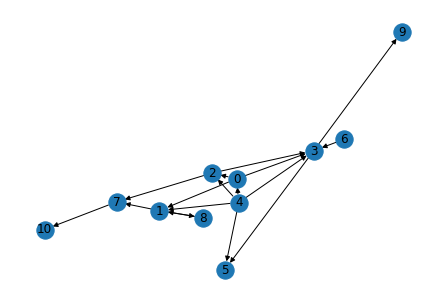

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3026.19it/s]

Time:  0.007142899999998065


[4, 2, 1]

In [15]:
graph=nx.DiGraph()
graph.add_edges_from([(0,"b"),(0,"c"),(0,"d"),("a","g"),("a",0),("a","b"),("a","d"),("a","c"),("c","d"),("k","d"),("c","f"),("b","e"),("b","f"),("d","g"),("e","b"),("d","h"),("f","m")])
graph=nx.convert_node_labels_to_integers(graph)
graph=set_weight_value(graph,0.5,"negative")
graph=set_weight_value(graph,0.5,"positive")
plt.figure()
pos=nx.spring_layout(graph)
nx.draw(graph,pos,with_labels=1)
plt.show()
BIOG(graph,[0],3,0.01)

In [7]:
def compute_threat_levels(G,S_N):
    s1= timeit.default_timer()
    G_source=G.copy()
    G_source.add_edges_from([("new",x) for x in S_N])
    
    DAG=nx.DiGraph()
    sign={}
    
    new_nodes= collections.deque()
    new_nodes.append("new")
    visited=set()
    
    order= []
    while new_nodes:
        vertex = new_nodes.pop()
        if vertex in visited:continue
        visited.add(vertex)
        order.append(vertex)
        for neighbor in list(G_source.successors(vertex)):
            if neighbor not in visited and neighbor not in DAG.nodes():
                DAG.add_edge(vertex,neighbor)
                new_nodes.append(neighbor)
                
    #print("DFS done")         
    #print(list(DAG.edges()))
    #print(list(reversed(list(nx.topological_sort(DAG)))))
    #print([(e[0],e[1]) for e in list(DAG.edges()) if e[1]==18])
    #plt.figure()
    #pos=nx.kamada_kawai_layout(DAG)
    #nx.draw(DAG,pos,with_labels=1)
    #plt.show()
    order=list(dict.fromkeys(order))
    #print(order)
    sigma={k:order.index(k) for k in order}
    sign={}
    for u in order:
        #print("u"+str(u)+str(list(DAG.predecessors(u))))
        sign[u]={}
        if u=="new":continue
        
        for p in DAG.predecessors(u):
            #print("p"+str(p))
            sign[u].update(sign[p])
            childreen= list(DAG.successors(p))
            if len(childreen)>1:
                sign[u][p]= u
                
    #print(sign)  
    #print(timeit.default_timer()-s1)
    for e in G.edges():
        if e[0] not in DAG.nodes() or e[1] not in DAG.nodes() or e in DAG.edges() or e[1] in S_N: continue   
        if sigma[e[1]]>=sigma[e[0]]: continue
        set1=set(sign[e[0]])
        set2=set(sign[e[1]])
        if  not set1.intersection(set2): continue
        #print("e"+str(e))
        #print(set1.intersection(set2),sign[e[0]])
        opts={key: sign[e[1]][key] for key in set1.intersection(set2)}
        wu1 = sign[e[0]][max(opts, key=opts.get)]
        #print(wu1,sigma[e[1]],sigma[wu1],sigma[e[0]])
        if sigma[e[1]]<sigma[wu1] and sigma[wu1]<=sigma[e[0]]:
            DAG.add_edge(e[0],e[1])
            #print("yes")
            
    #print(timeit.default_timer()-s1)        
    DAG.remove_nodes_from(["new"])
    print("DAG done")
    reversed_topological_ordering=list(reversed(list(nx.topological_sort(DAG))))
    #print(list(DAG.edges()))
    threat_levels={k:defaultdict(lambda: 0) for k in reversed_topological_ordering if k not in S_N}
    #print(threat_levels)
    for u in reversed_topological_ordering:
        if u in S_N: continue
        #print("u"+str(u))
        threat_levels[u][0]=1
        q_u={}
        for v in DAG.successors(u):
            q_u[v]= G[u][v]["negative"]*np.prod([1-G[parent][v]["negative"] for parent in list(G.predecessors(v)) if parent!=u])
        t=1 
        #print("q"+str(q_u))
        while any(threat_levels[x][t-1]!=0 for x in DAG.successors(u)):
            #print(t)
            for v in DAG.successors(u):
                threat_levels[u][t]+=q_u[v]*threat_levels[v][t-1]
                #print(v,t-1,threat_levels[u][t],threat_levels[v][t-1])
            t+=1
    
        #print(dict(threat_levels[u]))
    return  threat_levels,set([ k for k in reversed_topological_ordering if k not in S_N])   

#print("statr")
graph=nx.DiGraph()
graph.add_edges_from([(1,3),(3,2),(2,4),(2,6),(4,7),(7,4),(5,1),(5,8),(6,8),(3,5),(3,6),(7,6),(7,9),(6,9)])
#graph = nx.erdos_renyi_graph(10, 0.3, seed=123, directed=True)
graph=set_weight_value(graph,0.5,"negative")
graph=set_weight_value(graph,0.5,"positive")
t,S=compute_threat_levels(graph,[1,2])
print(S)
for i in t.keys():
    print(i,dict(t[i]))

DAG done
{3, 4, 5, 6, 7, 8, 9}
9 {0: 1, 1: 0, 2: 0}
8 {0: 1, 1: 0}
6 {0: 1, 1: 0.5, 2: 0}
7 {0: 1, 1: 0.375, 2: 0.0625, 3: 0}
5 {0: 1, 1: 0.25, 2: 0}
4 {0: 1, 1: 0.5, 2: 0.1875, 3: 0.03125}
3 {0: 1, 1: 0.625, 2: 0.1875}


In [17]:
print(not [1])

False


DAG done
here
{3, 4, 7, 9, '9copy1', '7copy1', '4copy1', '7copy2', '7copy3'}
{205: 1.089982473457127, 45: 0.31224517073425434, 28: 0.02941179672948071, 65: 0.03262910847789126, 35: 0.009783280300471629, 50: 0.0058823529411764705, 14: 0.0007355048407263813, 454: 0.0007765324116900093, 466: 0.0007352941176470588, 20: 0.0011996322560274978, 67: 0.0005882352941176471, 74: 0.00014705882352941178, 152: 0.0005892564910556392, 245: 2.67379679144385e-05, 120: 0.00038939682250259785, 146: 0.00024509803921568627, 57: 9.304525604791808e-06, 434: 0.00010366082030701019, 7: 0, 82: 3.676443672576616e-05, 150: 3.355496053238785e-05, 210: 3.0637254901960784e-05, 477: 3.46721228465059e-05, 3: 0, 149: 3.865154707280994e-05, 252: 1.1208751793400289e-07, 327: 1.1208751793400289e-07, 21: 8.169934640522877e-06, 332: 3.268445404437417e-05, 427: 8.169934640522877e-06, 63: 2.9711015038055536e-06, 305: 3.2612687312333866e-06, 399: 2.917705630399434e-06, 75: 1.0211969706398019e-05, 166: 1.0211969706398019e-05, 32

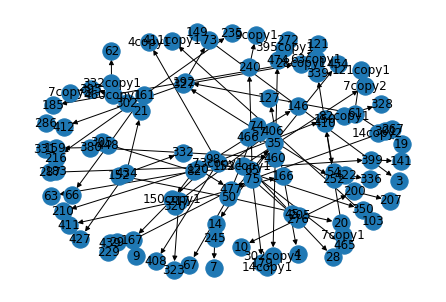

In [70]:
def generate_WRR(G,S,S_N,threat_levels,max_depth):
    s1= timeit.default_timer()
    WRR=nx.DiGraph()
    A,m,s=[],defaultdict(lambda: 0),{}
    r= random.choice(list(S))
    A.append((r,0))
    WRR.add_node(r)
    #print(r)
    original_node={}
    original_node[r]=r
    copies= defaultdict(lambda: 0)
    ancestors_u={r:set()}
    score={}
    S_N_WRR=set()
    while A:

        v,l = A.pop(0)
        
        v_original= original_node[v]
        if v==r: m[v]=1
        else: # compute mv
            if v in original_node: v_original=original_node[v]
            for c in WRR.predecessors(v):
                c_original=c
                if c in original_node: c_original=original_node[c]
                m[v]+=G[v_original][c_original]["negative"]*m[c] 

        s[v]=l

        if v_original not in S_N :
            if l>=max_depth: continue
            for u in G.predecessors(v_original):
                #print(v,u)
                if random.random() <= G[u][v_original]['negative'] :
                    #print("yes")
                    if u in WRR.nodes():
                        if u in ancestors_u[v]: 
                            #print("ups")
                            continue
                        copies[u]+=1
                        original_node[str(u)+"copy"+str(copies[u])]=u
                        WRR.add_edge(v,str(u)+"copy"+str(copies[u]))
                        A.append((str(u)+"copy"+str(copies[u]),s[v]+1))
                        ancestors_u[str(u)+"copy"+str(copies[u])]=set()    
                        ancestors_u[str(u)+"copy"+str(copies[u])].update(list(ancestors_u[v])+[v_original])
                    else:
                        WRR.add_edge(v,u)
                        A.append((u,s[v]+1))   
                        ancestors_u[u]=set()    
                        ancestors_u[u].update(list(ancestors_u[v])+[v_original])
                        original_node[u]= u
                        
                #print("no")
        else:
            
            S_N_WRR.add(v)       
    if list(S_N_WRR):
        for u in WRR.nodes():
            if not str(u).isnumeric():continue
            if u in S_N_WRR:
                score[u]=0 
                continue
            num_copies=copies[u]
            if num_copies==0:
                beta=m[u]*np.prod([(1-m[s_n]) for s_n in list(set(S_N_WRR)-set(ancestors_u[u])) if s[s_n]<s[u]])
                sum_threat=0
                t=0
                while threat_levels[u][t]!=0: sum_threat+=threat_levels[u][t]; t+=1 
                score[u]= beta* sum_threat
            else:
                score[u]=0
                beta=defaultdict(lambda: 0)
                copies_u=[str(u)+"copy"+str(i) for i in range(1,num_copies+1)]+[u]
                ancestors_total=set(x for copy in copies_u for x in ancestors_u[copy] )
                steps_u=set(s[copy] for copy in copies_u)
                sum_threat=0
                t=0
                while threat_levels[u][t]!=0: sum_threat+=threat_levels[u][t]; t+=1
                    
                for t in steps_u:
                    beta[t]=(1-np.prod([1-m[u_c] for u_c in copies_u if s[u_c]==t]))
                    beta[t]*=np.prod([(1-m[s_n]) for s_n in list(set(S_N_WRR)-set(ancestors_total)) if s[s_n]<t])
                    score[u]+=beta[t]*sum_threat
        #print(timeit.default_timer()-s1)
        #print(list(WRR.nodes()),list(original_node))
        return r,WRR,score,original_node,ancestors_u,s,m,S_N_WRR,copies # the returned WRR has to have S_N node
    

    else: 
        #print(timeit.default_timer()-s1)
        #print(list(WRR.nodes()),list(original_node))
        return None,WRR,None,None,None,None,None,None,None # the returned WRR has to have S_N node
    


#graph=nx.DiGraph()
#graph.add_edges_from([(1,3),(3,2),(2,4),(2,6),(4,7),(7,4),(5,1),(5,8),(6,8),(3,5),(3,6),(7,6),(7,9),(6,9)])
#graph = nx.erdos_renyi_graph(10, 0.3, seed=123, directed=True)
graph=Homo_BA.copy()
graph=set_weight_degree(graph,"negative")
graph=set_weight_degree(graph,"positive")
if True:
        for e in graph.edges():
            if graph.nodes[e[0]]['community']==graph.nodes[e[1]]['community']:
                    graph[e[0]][e[1]]["positive"]*=2
                    graph[e[0]][e[1]]["negative"]*=2
            else:
                    graph[e[0]][e[1]]["positive"]=0.5*graph[e[0]][e[1]]["positive"]
                    graph[e[0]][e[1]]["negative"]=0.5*graph[e[0]][e[1]]["negative"]

t,S=compute_threat_levels(graph,range(10))
print("here")
#print(dict(t),S)
r,WRR,score,original_node,S_N_u,s,m,S_N_WRR,c=generate_WRR(graph,S,range(10),t,10)
print(S_N_WRR)
print(score,c)
nx.draw(WRR,with_labels=1)

In [30]:
u="8copy1"
str(u).isnumeric()

False

In [76]:
def  Max_Coverage(RRs,k,G):
    start = timeit.default_timer()
    S_k=set()
    need_covering=[x for x in range(len(RRs))]
    for i in range(k):
        
        list_rr=[]
        for i in need_covering:
            list_rr+=RRs[i]
            
        options=Counter(list_rr)
        u = options.most_common(1)[0][0]
        
        need_covering=[x for x in need_covering if u not in RRs[x]]
        
        S_k.add(u)
        Cov_S_k= len(RRs)-len(need_covering)
    print(timeit.default_timer()-start)
    return S_k,Cov_S_k*len(G.nodes())/len(RRs)

def ipsilon(e,d):
    return (2+2/3*e)*np.log(1/d)*(1/(e**2))

def D_SSA(G,S,S_N,k,e,d,threat_levels,fair,max_depth):
    print("k"+str(k))
    n=len(list(G.nodes()))
    #print(n,e,d,k)
    N_max=8*((1-1/math.e)/(2+2*e/3))*(ipsilon(e,(d/6)/(n/k)))*n/k
    #print(N_max)
    t_max=math.ceil(np.log2(2*N_max/(ipsilon(e,d/3))))
    print(t_max)
    t=1
    Lambda=round(ipsilon(e,d/(3*t_max)))
    Lambda_1=1+(1+e)*ipsilon(e,d/(3*t_max))
    print(Lambda,Lambda_1)
    scores,WRRs,original_nodes,RRs,roots,S_N_u,s,m,S_N_WRR,copies={},{},{},{},{},{},{},{},{},{}
    for i in tqdm(range(Lambda*2**(t-1)), position=0, leave=True):
        
        if fair:roots[i],WRR,scores[i],original_nodes[i],S_N_u[i],s[i],m[i],S_N_WRR[i],copies[i]=generate_WRR_fair(G,S,S_N,threat_levels,max_depth)
        else:roots[i],WRR,scores[i],original_nodes[i],S_N_u[i],s[i],m[i],S_N_WRR[i],copies[i]=generate_WRR(G,S,S_N,threat_levels,max_depth)
        WRRs[i]=[e for e in WRR.edges()].copy()
        RRs[i]=[e for e in WRR.nodes()].copy()
        
    #print(len({k: v for k, v in roots.items() if v is not None}))
    #print(t,len(RRs))    
    while len(RRs)< N_max:
        
        scores_t,WRRs_t,original_nodes_t,RRs_t,roots_t,S_N_u_t,s_t,m_t,S_N_WRR_t,copies_t={},{},{},{},{},{},{},{},{},{}
        for i in tqdm(range(Lambda*2**(t-1),Lambda*2**t), position=0, leave=True):
            
            if fair:roots_t[i],WRR_t,scores_t[i],original_nodes_t[i],S_N_u_t[i],s_t[i],m_t[i],S_N_WRR_t[i],copies_t[i]=generate_WRR_fair(G,S,S_N,threat_levels,max_depth)
            else:roots_t[i],WRR_t,scores_t[i],original_nodes_t[i],S_N_u_t[i],s_t[i],m_t[i],S_N_WRR_t[i],copies_t[i]=generate_WRR(G,S,S_N,threat_levels,max_depth)
            
            WRRs_t[i]=[e for e in WRR_t.edges()].copy()
            RRs_t[i]=[e for e in WRR_t.nodes()].copy()
           
        S_k,I = Max_Coverage(RRs,k,G) 
        #Cov_S_k_t = np.sum([1 if not list(S_k & set(RRs_t[i])) else 0  for i in range(Lambda*2**(t-1),Lambda*2**t)])
        Cov_S_k_t = np.sum([1 if any([j in RRs_t[i] for j in S_k]) else 0 for i in range(Lambda*2**(t-1),Lambda*2**t)])
        print("cov"+str((Cov_S_k_t,len(RRs_t))))
        if Cov_S_k_t>= Lambda_1:
            I_t= Cov_S_k_t*n/len(RRs_t)
            print("Is "+str(I)+" "+str(I_t)+" "+str((I/I_t)))
            e1=(I/I_t)-1
            e2=e*np.sqrt((n*(1+e))/(2**(t-1)*I_t))
            e3=e*np.sqrt((n*(1+e)*(1-1/math.e-e))/((1+e/3)*2**(t-1)*I_t))
            e_t=(e1+e2+e1*e2)*(1-1/math.e-e)+(1-1/math.e)*e3
            print(e1,e2,e3)
            print("e_t"+str(e_t))
            if e_t<=e: return scores,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies
        
        t+=1
        scores.update(scores_t)
        WRRs.update(WRRs_t)
        original_nodes.update(original_nodes_t)
        RRs.update(RRs_t)
       
        roots.update(roots_t)
        S_N_u.update(S_N_u_t)
        s.update(s_t)
        m.update(m_t)
        copies.update(copies_t)
        S_N_WRR.update(S_N_WRR_t)
        print(t,len(RRs),len({k: v for k, v in roots.items() if v is not None}))
        
    return scores,WRRs,original_nodes,roots,RRs,S_N_u,s,m,S_N_WRR,copies
        

In [98]:
def TIB_Solver(G,S_N,k,max_depth):
    print("k"+str(k))
    start = timeit.default_timer()
    S_P=[]
    threat_levels,S,=compute_threat_levels(G,S_N)
    #print(sorted(list(threat_levels.keys())))
    scores,WRRs,original_nodes,roots,RRs,ancestors_u,s,m,S_N_WRR,copies= D_SSA(G,S,S_N,k,0.1,1/len(S),threat_levels,False,max_depth)
    WRRs_to_keep=[i for i in range(len(roots)) if roots[i] is not None]
    #print(len(WRRs_to_keep),len({k: v for k, v in roots.items() if v is not None}))
    
    scores={key:scores[key] for key in WRRs_to_keep}
    WRRs={key:WRRs[key] for key in WRRs_to_keep}
    original_nodes={key:original_nodes[key] for key in WRRs_to_keep}
    roots={key:roots[key] for key in WRRs_to_keep}
    RRs={key:RRs[key] for key in WRRs_to_keep}
    m={key:m[key] for key in WRRs_to_keep}
    s={key:s[key] for key in WRRs_to_keep}
    copies={key:copies[key] for key in WRRs_to_keep}
    ancestors_u={key:ancestors_u[key] for key  in WRRs_to_keep}
    #print(Counter(roots.values()))
    #print("how many are NONe")
    #print(len(WRRs_to_keep),len(roots))
    
    for i in tqdm(range(k), position=0, leave=True):
        s0=timeit.default_timer()
        options=[]
        best=(None,None,0)
        for i in WRRs_to_keep:
            for  key in scores[i].keys():
                if scores[i][key]<=best[2]: continue
                if original_nodes[i][key] not in S_N+S_P:
                    best=(key,i,scores[i][key])
                    
                options+=[(key,i,scores[i][key]) for key in scores[i].keys() if key not in S_N+S_P]
        #options=defaultdict(lambda: 0)   
        #for j in WRRs_to_keep:
            #for v in scores[j].keys():
               # if v not in S_N+S_P:
                   # options[v]+=scores[j][v]
        #options={key: np.sum([scores[i][key]  for i in WRRs_to_keep if key in scores[i].keys() and key not in S_P]) for key in list(G.nodes())} 
        #print(options)
        #print(timeit.default_timer()-s0)
        u,i,val = best
        
        #print(u,i,val)
        original_u=original_nodes[i][u]
        #u = max(options,key=options.get)
        #print("u ------> "+str(u)+" "+str(timeit.default_timer()-s0))
        S_P.append(original_u)
        
        for v in G.predecessors(original_u):
            if v not in S_N: 
                q_v_u= G[v][original_u]["negative"]*np.prod([1-G[parent][original_u]["negative"] for parent in list(G.predecessors(original_u)) if parent!=v])
                t=1
                while  threat_levels[v][t]!=0:
                    threat_levels[v][t]-=q_v_u*np.sum([threat_levels[original_u][t-s] for s in range(1,t+1)])
                    t+=1
                 
            
            for j in [ j for j in WRRs_to_keep if roots[j]==v]:
                for w in RRs[j]:
                    if w not in S_N_WRR[j] and str(w).isnumeric():
                        w_original= original_nodes[j][w]
                        num_copies=copies[j][w_original]
                        copies_w=[str(w)+"copy"+str(i) for i in range(1,num_copies+1)]+[w]
                        ancestors_total=set(x for copy in copies_w for x in ancestors_u[j][copy] )
                        steps_w=set(s[j][copy] for copy in copies_w)
                        sum_threat=0
                        t=0
                        while threat_levels[w][t]!=0: sum_threat+=threat_levels[w][t]; t+=1
                        scores[j][w]=0
                        beta=defaultdict(lambda: 0)
                        for t in steps_w:
                            beta[t]=(1-np.prod([1-m[j][w_c] for w_c in copies_w if s[j][w_c]==t]))
                            beta[t]*=np.prod([(1-m[j][s_n]) for s_n in list(set(S_N_WRR[j])-set(ancestors_total)) if s[j][s_n]<t])
                            scores[j][w]+=beta[t]*sum_threat
                        
                        
                        
        #print(timeit.default_timer()-s0)
        time1,time2,time3,time4=0,0,0,0
        for j in [j for j in WRRs_to_keep if original_u in RRs[j]]:
            if roots[j] in G.predecessors(original_u): continue
            
            s4=timeit.default_timer()
            S_P_T=[]
            steps_S_P={x:s[j][x] for x in RRs[j] if original_nodes[j][x] in S_P}
            #print(steps_S_P)
            for v,_ in sorted(steps_S_P.items(), key=lambda x: x[1], reverse=False):
                if list(set(S_P_T)&ancestors_u[j][v]): continue
                S_P_T.append(v) 
            Z_S_N_u=set(S_N_WRR[j])-set([x for v in S_P_T for x in ancestors_u[j][v]])
            steps_Z=[s[j][x] for x in S_P_T ]
            beta_Z=defaultdict(lambda: 0)
            for t in set(steps_Z):
                beta_Z[t]=(1-np.prod([(1-m[j][v]) for v in S_P_T if s[j][v]==t]))*np.prod([(1-m[j][v]) for v in  Z_S_N_u if s[j][v]<t])
                        
            time4+=timeit.default_timer()-s4    
            
            for w in RRs[j]:
                 
                if w not in S_N_WRR[j] and w not in list(set(S_P)-set([u])):
                    #print(w)
                    s1=timeit.default_timer()
                    original_w=original_nodes[j][w]
                    if original_w==original_u: 
                        scores[j][w]=0
                        continue
                    

                    S_P_w_T=S_P_T.copy() 
                    can_we_add_w=True
                    for v in [v for v in S_P_T if steps_S_P[v]< s[j][w]]:
                        if v in list(ancestors_u[j][w]): 
                            can_we_add_w=False
                            break
                    if can_we_add_w:
                        S_P_w_T.append(w) 
                        for v in [v for v in S_P_T if steps_S_P[v]>= s[j][w]]:
                            if w in list(ancestors_u[j][v]): 
                                S_P_w_T.remove(v) 
                    
                    #print("S_P"+str(S_P_T)+" "+str(S_P_w_T)) 
                    if S_P_T==S_P_w_T: 
                        scores[j][w]=0
                        continue
                        
                    Z_w_S_N_u=set(S_N_WRR[j])-set([x for v in S_P_w_T for x in ancestors_u[j][v]])
                    #print("Z"+str(Z_S_N_u)+" "+str(Z_w_S_N_u))
                    
                    
                    
                    steps_Z_w=[s[j][x] for x in S_P_w_T]
                    
                    
                    #print(Z_S_N_u,Z_w_S_N_u)
                    beta_Z_w=defaultdict(lambda: 0)
                    
                    time1+=timeit.default_timer()-s1
                    
                    s2=timeit.default_timer()
                    
                    for t in set(steps_Z_w):
                        beta_Z_w[t]=(1-np.prod([(1-m[j][v]) for v in S_P_w_T if s[j][v]==t]))*np.prod([(1-m[j][v]) for v in  Z_w_S_N_u if s[j][v]<t])
                    #print(beta_Z,beta_Z_w)
                    time2+=timeit.default_timer()-s2
                    
                    s3=timeit.default_timer()
                    t=0
                    scores[j][w]=0
                    while (beta_Z[t]!=0 or beta_Z_w[t]!=0):
                        scores[j][w]+=(beta_Z_w[t]-beta_Z[t])* threat_levels[roots[j]][t-1]
                        t+=1
                    #print(scores[j][w])
                    time3+=timeit.default_timer()-s3
        #print(time1,time2,time3,time4)
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P      


if False:
    print("hi ")
    network=Facebook.copy()
    network=network.to_directed(as_view=False)
    communities= [network.nodes[v]['community'] for v in network.nodes()]

    network=set_weight_degree(network,"positive")
    network=set_weight_degree(network,"negative")
    if True:
        for e in network.edges():
            if network.nodes[e[0]]['community']==network.nodes[e[1]]['community']:
                    network[e[0]][e[1]]["positive"]*=1.1
                    network[e[0]][e[1]]["negative"]*=1.1
            else:
                    network[e[0]][e[1]]["positive"]=0.9*network[e[0]][e[1]]["positive"]
                    network[e[0]][e[1]]["negative"]=0.9*network[e[0]][e[1]]["negative"]

    partition={}
    d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])
    for v in list(network.nodes()):
        partition[v]=d[network.nodes[v]['community']]

    k_n=50
    k_p=100

    S_N=candidates=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]     
    #S_N=random.choices([v for v in list(network.nodes()) if network.out_degree(v)!=0],k= k_n)
    print(S_N,[network.out_degree(u) for u in S_N])    
    print(TIB_Solver(network,S_N,k_p))
if True:    
    graph=nx.DiGraph()
    graph.add_edges_from([(1,3),(3,2),(2,4),(2,6),(4,7),(7,4),(5,1),(5,8),(6,8),(3,5),(3,6),(7,6),(7,9),(6,9)])
    #graph = nx.erdos_renyi_graph(10, 0.3, seed=123, directed=True)
    graph=set_weight_value(graph,0.5,"negative")
    graph=set_weight_value(graph,0.5,"positive")
    print(TIB_Solver(graph,[1,2],3,max_depth=10))

k3
DAG done
k3
5
962 1059.000319602477


100%|█████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 15812.61it/s]


0.0010535000001254957
cov(782, 962)
2 1924 874


100%|███████████████████████████████████████████████████████████████████████████| 1924/1924 [00:00<00:00, 16558.21it/s]


0.001884500000414846
cov(1538, 1924)
Is 7.222453222453223 7.1943866943866945 1.0039011703511054
0.0039011703511053764 0.08294796024757191 0.059523781054695406
e_t0.08401260473749747


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.23it/s]

Time:  0.3657524000000194
[3, 4, 6]


In [ ]:
def TIB_Solver_fair(G,S_N,k):
    print("k"+str(k))
    start = timeit.default_timer()
    S_P=[]
    threat_levels,S,=compute_threat_levels_fair(G,S_N)
    scores,WRRs,original_nodes,roots,RRs,ancestors_u,s,m,S_N_WRR= D_SSA(G,S,S_N,k,0.1,1/len(S),threat_levels,True)
    WRRs_to_keep=[i for i in range(len(roots)) if roots[i] is not None]
    
    scores={key:scores[key] for key in WRRs_to_keep}
    WRRs={key:WRRs[key] for key in WRRs_to_keep}
    original_nodes={key:original_nodes[key] for key in WRRs_to_keep}
    roots={key:roots[key] for key in WRRs_to_keep}
    RRs={key:RRs[key] for key in WRRs_to_keep}
    m={key:m[key] for key in WRRs_to_keep}
    s={key:s[key] for key in WRRs_to_keep}
    ancestors_u={key:ancestors_u[key] for key  in WRRs_to_keep}
    
    for i in tqdm(range(k), position=0, leave=True):
        s0=timeit.default_timer()
        options=[]
        for i in WRRs_to_keep:
            options+=[(key,scores[i][key]) for key in scores[i].keys() if key not in S_N+S_P]
        #options={key: max([scores[i][key]  for i in WRRs_to_keep if key in scores[i].keys() and key not in S_P],default=0) for key in list(G.nodes())} 
        u = max(options,key=itemgetter(1))[0] 
        #print(timeit.default_timer()-s0)
        #print("u ------> "+str(u))
        S_P.append(u)
        
        for v in G.predecessors(u):
            if v not in S_N: 
                q_v_u= G[v][u]["negative"]*np.prod([1-G[parent][u]["negative"] for parent in list(G.predecessors(u)) if parent!=v])
                t=1
                while threat_levels[v][t]!=0 :
                    threat_levels[v][t]-=q_v_u*threat_levels[u][t-1]
                    t+=1
            
            for j in [ j for j in WRRs_to_keep if roots[j]==v]:
                for w in  RRs[j]:
                    if w not in S_N_WRR[j]:
                        w_original=w
                        if w in original_nodes[j]: w_original=original_nodes[j][w]
                        beta=m[j][w]*np.prod([(1-m[j][s_n]) for s_n in list(set(S_N_WRR[j])-set(ancestors_u[j][w])) if s[j][s_n]<s[j][w]])
                        scores[j][w]= beta*np.sum([threat_levels[roots[j]][t] for t in range(s[j][w])])
        #print(timeit.default_timer()-s0)
        time1,time2,time3,time4=0,0,0,0
        for j in [j for j in WRRs_to_keep if u in RRs[j]]:
            if roots[j] in G.predecessors(u): continue
            #print(RRs[j])
            #g=nx.DiGraph()
            #g.add_edges_from(WRRs[j])
           
            #plt.figure()
            #pos=nx.kamada_kawai_layout(g)
            #nx.draw(g,pos,with_labels=1)
            #plt.show()
            
            scores[j][u]=0
            for w in RRs[j]:
                
                if w not in S_N_WRR[j] and w not in S_P:
                     #print(w)
                    s1=timeit.default_timer()
                    original_w=w
                    if w in original_nodes[j]: original_w=original_nodes[j][w]
                    
                    s4=timeit.default_timer()
                    S_P_T,S_P_w_T=[],[]
                    
                    steps_S_P={x:s[j][x] for x in S_P if x in RRs[j]}
                     #print(steps_S_P)
                    for v,_ in sorted(steps_S_P.items(), key=lambda x: x[1], reverse=False):
                        if list(set(S_P_T)&ancestors_u[j][v]): continue
                        S_P_T.append(v) 
                        
                        
                    S_P_w_T=S_P_T.copy() 
                    can_we_add_w=True
                    for v in [v for v in S_P_T if steps_S_P[v]< s[j][w]]:
                        if v in list(ancestors_u[j][w]): 
                            can_we_add_w=False
                            break
                    if can_we_add_w:
                        S_P_w_T.append(w) 
                        for v in [v for v in S_P_T if steps_S_P[v]>= s[j][w]]:
                            if w in list(ancestors_u[j][v]): 
                                S_P_w_T.remove(v) 
                    
                     #print("S_P"+str(S_P_T)+" "+str(S_P_w_T)) 
                    Z_S_N_u=set(S_N_WRR[j])-set([x for v in S_P_T for x in ancestors_u[j][v]])
                    Z_w_S_N_u=set(S_N_WRR[j])-set([x for v in S_P_w_T for x in ancestors_u[j][v]])
                     #print("Z"+str(Z_S_N_u)+" "+str(Z_w_S_N_u))
                    
                    time4+=timeit.default_timer()-s4
                    steps_Z=[s[j][x] for x in S_P_T ]
                    steps_Z_w=[s[j][x] for x in S_P_w_T]
                    
                    
                    #print(Z_S_N_u,Z_w_S_N_u)
                    beta_Z,beta_Z_w=defaultdict(lambda: 0),defaultdict(lambda: 0)
                    
                    time1+=timeit.default_timer()-s1
                    
                    s2=timeit.default_timer()
                    for t in steps_Z:
                        beta_Z[t]=(1-np.prod([(1-m[j][v]) for v in S_P_T if s[j][v]==t]))*np.prod([(1-m[j][v]) for v in  Z_S_N_u if s[j][v]<t])
                    for t in steps_Z_w:
                        #print(t)
                        #print([(v,nx.ancestors(g,v)) for v  in S_P+[w] if s[j][v]==t])
                        beta_Z_w[t]=(1-np.prod([(1-m[j][v]) for v in S_P_w_T if s[j][v]==t]))*np.prod([(1-m[j][v]) for v in  Z_w_S_N_u if s[j][v]<t])
                    #print(beta_Z,beta_Z_w)
                    time2+=timeit.default_timer()-s2
                    
                    s3=timeit.default_timer()
                    t=0
                    scores[j][w]=0
                    while (beta_Z[t]!=0 or beta_Z_w[t]!=0):
                        scores[j][w]+=(beta_Z_w[t]-beta_Z[t])* np.sum([threat_levels[roots[j]][t] for t in range(s[j][w])])
                        t+=1
                    #print(scores[j][w])
                    time3+=timeit.default_timer()-s3
        #print(time1,time2,time3,time4)
    stop = timeit.default_timer()
    print('Time: ', stop - start)   
    return S_P      

print("hi ")
network=Facebook.copy()
network=network.to_directed(as_view=False)
communities= [network.nodes[v]['community'] for v in network.nodes()]

network=set_weight_degree(network,"positive")
network=set_weight_degree(network,"negative")

partition={}
d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])
for v in list(network.nodes()):
    partition[v]=d[network.nodes[v]['community']]

k_n=50
k_p=100

S_N=candidates=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]     
#S_N=random.choices([v for v in list(network.nodes()) if network.out_degree(v)!=0],k= k_n)
print(S_N,[network.out_degree(u) for u in S_N])    
print(TIB_Solver(network,S_N,k_p))

In [95]:
#functions used in the MCICM simulation
def set_all_Neu(G): # function to seet all nodes to neutral
    for i in G.nodes():
        G.nodes[i]['action'] = 'Neu'
    return G   

def set_Neg(G, list1): # function to set nodes in the negative seed to negative and active (Neg_a)
    for i in list1:
        G.nodes[i]['action'] = 'Neg_a'
    return G   

def set_Pos(G, list1): # function to set nodes in the positive seed to positive and active (Pos_a)
    for i in list1:
        G.nodes[i]['action'] = 'Pos_a'
    return G 

def get_colors(G): #functions to translate state to color for visualization
    color = []
    for i in G.nodes():
        if (G.nodes[i]['action'] == 'Neg' or G.nodes[i]['action'] == 'Neg_a'):
            color.append('red')
        elif (G.nodes[i]['action'] == 'Pos'or G.nodes[i]['action'] == 'Pos_a'):
            color.append('green')
        else:
            color.append('blue')
    return color

def recalculate(G,negative,positive): # function to update the state of each node after a step
    dict1 = {}
    new_pos=[]
    new_neg=[]
    
    while positive: # the positive nodes have preference
        i=positive.pop()
        neigh = G.neighbors(i)
        for j in neigh:
            p=random.random()
            if (G.nodes[j]['action'] == 'Neu' and p<=G[i][j]['positive']): # if node has no opinion yet 
                G.nodes[j]['action'] = 'Pos_a'
                new_pos.append(j)
        G.nodes[i]['action'] = 'Pos' # and the node is no longer active
        
    while negative:
        i=negative.pop()
        neigh = G.neighbors(i)
        for j in neigh:
            p=random.random()
            if (G.nodes[j]['action'] == 'Neu' and p<=G[i][j]['negative']):
                G.nodes[j]['action'] = 'Neg_a'
                new_neg.append(j)
        G.nodes[i]['action'] = 'Neg' # and the node is no longer active
    return G,new_pos,new_neg



def inf_loop(node,infected,G,p_n):
    neigh = G.successors(node)
    for j in neigh:
        p=random.random()
        if (G.nodes[j]['action'] == 'Neu' and p<=G[node][j][p_n]): # if node has no opinion yet 
                infected.append(j)
    return infected


def recalculate_parallel(G,negative,positive): # function to update the state of each node after a step
    
    new_pos=[]
    Parallel(n_jobs=-1, backend="threading")(delayed(inf_loop)(x, new_pos,G,"positive") for x in positive)
    new_pos=list(dict.fromkeys(new_pos))
    for i in positive: G.nodes[i]['action'] = 'Pos'
    for i in new_pos: G.nodes[i]['action'] = 'Pos_a'
    
    
    new_neg=[]
    Parallel(n_jobs=-1, backend="threading")(delayed(inf_loop)(x, new_neg,G,"negative") for x in negative)
    new_neg=list(dict.fromkeys(new_neg))
    for i in negative : G.nodes[i]['action'] = 'Neg'
    for i in new_neg: G.nodes[i]['action'] = 'Neg_a'
    
    return G,new_pos,new_neg
                
def Calculate(G,n,S_N,S_P): # function that given a graph G with nodes in different states runs a MCICM for n iterations
    pos,neg=S_P.copy(),S_N.copy()
    keep_going = True
    count = 0
    while (keep_going):
        count += 1
        if count>30: print(count,neg)
        G,pos,neg=recalculate_parallel(G,neg,pos)
        if not neg: # if no new nodes are infected  
            keep_going = False 
    return G

def MCICM(G,S_N,S_P,partition,tot,tot_per_com):
    G1 = G.copy()
    G1=set_Pos(set_Neg(set_all_Neu(G1),S_N),S_P)
    G1=Calculate(G1,100,S_N,S_P)
    colors = get_colors(G1)
    communities=get_communities(partition,G)
    infection_comm=[0]*communities    
      
    for i in list(set(G.nodes())-set(S_N)):
        if colors[i]=='red':  
            infection_comm[partition[i]]+=1 
    total=sum(infection_comm) 
    return tot.append(total), tot_per_com.append(infection_comm)



In [ ]:
print("now")
network=Homo_BA.copy()
network=network.to_directed(as_view=False)
communities= [network.nodes[v]['community'] for v in network.nodes()]
num_com=len(np.unique(communities))

network=set_weight_degree(network,"positive")
network=set_weight_degree(network,"negative")



#network=set_weight_random_power(network)
#network=set_weight_trivalency(network,"positive")
#network=set_weight_trivalency(network,"negative")
#network=set_weight_random(network,0.15,"positive")
#network=set_weight_random(network,0.1,"negative")
#network=set_weight_degree(network)
#network=set_weight_comm(network,[[0.1,0.02],[0.01,0.05]],"positive")
#network=set_weight_comm(network,[[0.05,0.01],[0.02,0.1]],"positive")
#network=set_weight_comm(network,[[0.1,0.02],[0.01,0.05]],"negative")
if True:
    for e in network.edges():
        if network.nodes[e[0]]['community']==network.nodes[e[1]]['community']:
                network[e[0]][e[1]]["positive"]*=1.1
                network[e[0]][e[1]]["negative"]*=1.1
        else:
                network[e[0]][e[1]]["positive"]=0.9*network[e[0]][e[1]]["positive"]
                network[e[0]][e[1]]["negative"]=0.9*network[e[0]][e[1]]["negative"]
                
#network=set_weight_increase(network,[[0.02,0.001],[0,0.01]],"negative")
#network=set_weight_increase(network,[[0.01,0],[0.001,0.02]],"positive")
print(len(network.nodes()))
print(np.mean([network[e[0]][e[1]]["positive"] for e in network.edges()]))
print(np.mean([network[e[0]][e[1]]["negative"] for e in network.edges()]))
print(np.mean([network.out_degree(v) for v in network.nodes()]))
#partition = community_louvain.best_partition(network.to_undirected(reciprocal=False, as_view=False), random_state=10)
partition={}


print(num_com)
d=dict([(y,x) for x,y in enumerate(sorted(set(communities)))])

for v in list(network.nodes()):
    partition[v]=d[network.nodes[v]['community']]
      


pop_communities=[0]*num_com    
for c in range(num_com):
    pop_communities[c]=[v for k,v in partition.items()].count(c)
print("population is"+str(pop_communities))

k_n=50
k_p=100

S_N=[]
#S_N=candidates=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True)][0:k_n]       
#S_N=random.choices(list(network.nodes()),weights=[1/pop_communities[partition[v]] for v in network.nodes()],k= k_n)
S_N=random.choices([v for v in list(network.nodes()) if network.out_degree(v)!=0],k= k_n)
#S_N=random.choices([v for v in list(network.nodes())],k= k_n)
#S_N=[t[0] for t in sorted(network.out_degree, key=lambda x: x[1], reverse=True) if partition[t[0]]==1][0:k_n]  

print("S_N"+str(S_N))
print([network.out_degree(u) for u in S_N])    


comm=[0]*num_com
for i in S_N:
    comm[partition[i]]+=1
    
print("rate of infectees per community"+str(comm))

iterations=100


base=[]
base_total=[]
nodes_infected={}

Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,[],partition,base_total,base) for x in tqdm(range(iterations), position=0, leave=True))

base=[np.mean(base, axis=0)[c] for c in range(num_com)]
print(np.mean(base_total))
print(base)
print([base[c]/pop_communities[c] for c in range(num_com)])

CMIA_results_t, fair_results_t,fair_quick_results_t,degree_results_t,cent_results_t,TIB_results_t=[base_total],[base_total],[base_total],[base_total],[base_total],[base_total]
CMIA_inf,fair_inf,fair_quick_inf ,degree_inf,cent_inf,TIB_inf=[base],[base],[base],[base],[base],[base]

#value=min([(pop_communities[c]-base[c])/pop_communities[c] for c in range(num_com)])
CMIA_results_f, fair_results_f,fair_quick_results_f,degree_results_f,cent_results_f,TIB_results_f=[0],[0],[0],[0],[0],[0]
#CMIA_results_f,CMIA_fair_results_f,degree_results_f=[value],[value],[value]
number_values=10

times=[]
methods=[]

start = timeit.default_timer()
print("TIB-Solver")
candidates_TIB=TIB_Solver(network,S_N,k_p,10)
times.append(timeit.default_timer()-start)
methods.append("TIB-Solver")

start = timeit.default_timer()
degrees=[]
for x in list(network.nodes()):
    degrees.append((x,len(list(network.successors(x)))))
    
candidates_deg= [t[0] for t in sorted(degrees, key=lambda x: x[1], reverse=True) if  not t[0] in S_N]
times.append(timeit.default_timer()-start)
methods.append("degree")

start = timeit.default_timer()

centrality = nx.eigenvector_centrality(network)
candidates_centrality= [x for x in dict(sorted(centrality.items(), key=lambda item: item[1])).keys()]
times.append(timeit.default_timer()-start)
methods.append("Centrality")

start = timeit.default_timer()
print("CMIA_O")
#candidates_cmia=CMIA_O_fair_new_rec(network,S_N,k_p,0.01,partition)
candidates_cmia=CMIA_O(network,S_N,k_p,0.01)
#candidates_cmia=random.choices([v for v in list(set(network.nodes())-set(S_N))],k= k_p)
times.append(timeit.default_timer()-start)
methods.append("CMIA-O")


start = timeit.default_timer()
print(" quick ")
candidates_fair_quick=BIOG(network,S_N,k_p,0.01)
times.append(timeit.default_timer()-start)
methods.append(" quick help")


start = timeit.default_timer()
print("maximin help")
candidates_fair=CMIA_O_fair_new(network,S_N,k_p,0.01,partition)
times.append(timeit.default_timer()-start)
methods.append("maximin help")





min_inf=10
start=5
for i in tqdm(np.linspace(start, k_p, num=number_values,dtype=int)): 
    k_p=i.copy()
    print("buget is "+str(k_p))
    
    CMIA,fair,fair_quick,degree,cent,TIB=[],[],[],[],[],[]
    CMIA_t,fair_t,fair_quick_t,degree_t,cent_t,TIB_t=[],[],[],[],[],[]
    
    S_P_deg= sorted(candidates_deg[0:k_p])
    S_P_cent= sorted(candidates_centrality[0:k_p])
    S_P=sorted(candidates_cmia[0:k_p])
    S_P_fair=sorted(candidates_fair[0:k_p])
    S_P_fair_quick=sorted(candidates_fair_quick[0:k_p])
    S_P_TIB=sorted(candidates_TIB[0:k_p])
    #print(S_P_deg,S_P_cent,S_P,S_P_fair,S_P_fair_quick,S_P_TIB)

    
    
    CMIA_f,fair_f,fair_quick_f,degree_f,cent_f,TIB_f=[],[],[],[],[],[]
    inf_CMIA_f,inf_fair_f,inf_fair_quick_f,inf_degree_f,inf_cent_f,inf_TIB_f={},{},{},{},{},{}
    
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P,partition,CMIA_t,CMIA_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("CMIA"+str(np.mean(CMIA_t)))
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_fair ,partition,fair_t,fair_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("maximin_CMIA"+str(np.mean(fair_t)))
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_fair_quick ,partition,fair_quick_t,fair_quick_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("quick"+str(np.mean(fair_quick_t)))
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_deg ,partition,degree_t,degree_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("degree"+str(np.mean(degree_t)))
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_cent ,partition,cent_t,cent_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("Centrality"+str(np.mean(cent_t)))
    Parallel(n_jobs=-1, backend="threading")(delayed(MCICM)(network,S_N,S_P_TIB ,partition,TIB_t,TIB_f) for x in tqdm(range(iterations), position=0, leave=True))
    print("TIB"+str(np.mean(TIB_t)))
    
        
        
    degree_f=[np.mean(degree_f, axis=0)[c] for c in range(num_com)]
    degree_inf.append(degree_f)
    
    cent_f=[np.mean(cent_f, axis=0)[c] for c in range(num_com)]
    cent_inf.append(cent_f)
    
    CMIA_f=[np.mean(CMIA_f, axis=0)[c] for c in range(num_com)] 
    CMIA_inf.append(CMIA_f)
    
    fair_f=[np.mean(fair_f, axis=0)[c] for c in range(num_com)] 
    fair_inf.append(fair_f)
    
    fair_quick_f=[np.mean(fair_quick_f, axis=0)[c] for c in range(num_com)] 
    fair_quick_inf.append(fair_quick_f)
    
    TIB_f=[np.mean(TIB_f, axis=0)[c] for c in range(num_com)] 
    TIB_inf.append(TIB_f)
    
    
    
    degree_results_t.append(degree_t)
    degree_results_f.append(np.min([max((base[c]-degree_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("degree"+str([(max((base[c]-degree_f[c])/base[c],0),base[c],degree_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    cent_results_t.append(cent_t)
    cent_results_f.append(np.min([max((base[c]-cent_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    print("cent"+str([(max((base[c]-cent_f[c])/base[c],0),base[c],cent_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    CMIA_results_t.append(CMIA_t)
    CMIA_results_f.append(np.min([max((base[c]-CMIA_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("CMIA"+str([(max((base[c]-CMIA_f[c])/base[c],0),base[c],CMIA_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    fair_results_t.append(fair_t)
    fair_results_f.append(np.min([max((base[c]-fair_f[c])/base[c],0) if base[c]>=min_inf else 1  for c in range(num_com)]))
    print("maximin CMIA"+str([(max((base[c]-fair_f[c])/base[c],0),base[c],fair_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    fair_quick_results_t.append(fair_quick_t)
    fair_quick_results_f.append(np.min([max((base[c]-fair_quick_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("quick"+str([(max((base[c]-fair_quick_f[c])/base[c],0),base[c],fair_quick_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    TIB_results_t.append(TIB_t)
    TIB_results_f.append(np.min([max((base[c]-TIB_f[c])/base[c],0) if base[c]>=min_inf else 1 for c in range(num_com)]))
    print("TIB"+str([(max((base[c]-TIB_f[c])/base[c],0),base[c],TIB_f[c]) if base[c]>=min_inf else 1 for c in range(num_com) ]))
    
    print(np.mean(degree_results_t, axis=1),np.mean(cent_results_t, axis=1),np.mean(CMIA_results_t, axis=1),np.mean(fair_results_t, axis=1),np.mean(fair_quick_results_t, axis=1),np.mean(TIB_results_t, axis=1))
    print(degree_results_f,cent_results_f,CMIA_results_f,fair_results_f,fair_quick_results_f,TIB_results_f)
    #print(degree_f,cent_f,CMIA_f,fair_f,fair_quick_f,TIB_f)
    print()
    
x=[0]
x.extend(np.linspace(start, k_p, num=number_values,dtype=int))
print(x)
plt.style.use('default')
plt.figure(1)


mean=np.mean(degree_results_t, axis=1)
plt.plot(x, mean, '--bo', color='blue', label='degree') 

mean=np.mean(cent_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#EE1289' , label='EVC')

mean=np.mean(fair_results_t, axis=1)
plt.plot(x, mean,'--bo', color='#32CD32' , label='maximin CMIA')

mean=np.mean(fair_quick_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#FFFF00' ,label='maximin quick')

mean=np.mean(CMIA_results_t, axis=1)
plt.plot(x,mean, '--bo', color='red' , label=' CMIA')

mean=np.mean(TIB_results_t, axis=1)
plt.plot(x,mean, '--bo', color='#ff6600' , label=' TIB')


plt.legend()
                   
plt.figure(2)
plt.plot(x, degree_results_f, '--bo', label='degree')
plt.plot(x,cent_results_f, '--bo', label='Centrality EVC',color='pink')
plt.plot(x, fair_results_f, '--bo', label='maximin CMIA',color='green')
plt.plot(x, fair_quick_results_f, '--bo', label='maximin quick',color='yellow')
plt.plot(x, CMIA_results_f, '--bo', label='CMIA-O',color='red')
plt.plot(x, TIB_results_f, '--bo', label='TIB',color='#ff6600')
plt.legend()

plt.figure(3)
plt.plot(x, [x[0]/sum(x) for x in degree_inf], '--bo', label='degree')
plt.plot(x,[x[0]/sum(x) for x in cent_inf], '--bo', label='Centrality EVC',color='pink')
plt.plot(x, [x[0]/sum(x) for x in fair_inf], '--bo', label='maximin CMIA',color='green')
plt.plot(x, [x[0]/sum(x) for x in fair_quick_inf], '--bo', label='maximin quick',color='yellow')
plt.plot(x, [x[0]/sum(x) for x in CMIA_inf], '--bo', label='CMIA-O',color='red')
plt.plot(x, [x[0]/sum(x) for x in TIB_inf], '--bo', label='TIB',color='#ff6600')
plt.legend()

plt.figure(4)
plt.plot(x, [x[1]/sum(x) for x in degree_inf], '--bo', label='degree')
plt.plot(x,[x[1]/sum(x) for x in cent_inf], '--bo', label='Centrality EVC',color='pink')
plt.plot(x, [x[1]/sum(x) for x in fair_inf], '--bo', label='maximin CMIA',color='green')
plt.plot(x, [x[1]/sum(x) for x in fair_quick_inf], '--bo', label='maximin quick',color='yellow')
plt.plot(x, [x[1]/sum(x) for x in CMIA_inf], '--bo', label='CMIA',color='red')
plt.plot(x, [x[1]/sum(x) for x in TIB_inf], '--bo', label='TIB',color='#ff6600')
plt.legend()
                   
plt.figure(5)
plt.bar(methods, times, color ='maroon', width = 0.4)
plt.show()

now
500
0.08811688712135166
0.08811688712135166
11.784
2
population is[100, 400]
S_N[265, 306, 204, 143, 456, 364, 141, 199, 463, 295, 251, 483, 472, 94, 138, 443, 401, 114, 273, 246, 121, 191, 180, 340, 382, 415, 39, 190, 173, 348, 73, 293, 39, 457, 139, 3, 188, 102, 306, 168, 443, 234, 86, 41, 81, 166, 62, 255, 368, 240]
[7, 10, 8, 9, 6, 7, 12, 7, 6, 9, 7, 6, 7, 10, 9, 7, 8, 10, 8, 15, 8, 12, 11, 12, 6, 9, 20, 7, 6, 6, 21, 9, 20, 6, 21, 12, 9, 14, 10, 13, 7, 11, 9, 26, 19, 17, 27, 8, 6, 10]
rate of infectees per community[11, 39]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.58it/s]


142.41
[26.75, 115.66]
[0.2675, 0.28915]
TIB-Solver
k100
DAG done
k100
6
1861 2048.423989488205


100%|████████████████████████████████████████████████████████████████████████████| 1861/1861 [00:00<00:00, 2102.39it/s]


0.02615960000002815
cov(1115, 1861)
2 3722 1084


100%|████████████████████████████████████████████████████████████████████████████| 3722/3722 [00:01<00:00, 2532.49it/s]


0.09236079999982394
cov(2329, 3722)
Is 343.4981192907039 312.86942504030094 1.0978960927436667
0.09789609274366673 0.09375291608460337 0.06727745966993225
e_t0.14939166907139495
3 7444 2232


100%|████████████████████████████████████████████████████████████████████████████| 7444/7444 [00:02<00:00, 2650.12it/s]


0.14492609999979322
cov(4721, 7444)
Is 334.6990865126276 317.101020956475 1.0554967167972888
0.05549671679728885 0.06584950716391234 0.04725386417321879
e_t0.0963855576394967


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.44it/s]


Time:  13.847811399999955
CMIA_O


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Time:  93.03196829999979
 quick 


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.63it/s]


Time:  4.154517499999656
maximin help
436


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Time:  125.56935089999979


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

buget is 5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.12it/s]


CMIA79.48


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.25it/s]


maximin_CMIA78.91


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.10it/s]


quick91.5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


degree82.57


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.70it/s]


Centrality134.34


 10%|████████▎                                                                          | 1/10 [00:43<06:33, 43.70s/it]

TIB111.47
degree[(0.49271028037383174, 26.75, 13.57), (0.4034238284627356, 115.66, 69.0)]
cent[(0.07289719626168222, 26.75, 24.8), (0.05291371260591381, 115.66, 109.54)]
CMIA[(0.4852336448598131, 26.75, 13.77), (0.43186927200415015, 115.66, 65.71)]
maximin CMIA[(0.4900934579439252, 26.75, 13.64), (0.4356735258516341, 115.66, 65.27)]
quick[(0.41345794392523366, 26.75, 15.69), (0.344544354141449, 115.66, 75.81)]
TIB[(0.1917757009345794, 26.75, 21.62), (0.22315407228082312, 115.66, 89.85)]
[142.41  82.57] [142.41 134.34] [142.41  79.48] [142.41  78.91] [142.41  91.5 ] [142.41 111.47]
[0, 0.4034238284627356] [0, 0.05291371260591381] [0, 0.43186927200415015] [0, 0.4356735258516341] [0, 0.344544354141449] [0, 0.1917757009345794]

buget is 15


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.76it/s]


CMIA65.22


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.41it/s]


maximin_CMIA64.95


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.98it/s]


quick81.1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.71it/s]


degree60.16


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.24it/s]


Centrality121.33


 20%|████████████████▌                                                                  | 2/10 [01:28<05:53, 44.18s/it]

TIB96.52
degree[(0.645607476635514, 26.75, 9.48), (0.561819125021615, 115.66, 50.68)]
cent[(0.15102803738317755, 26.75, 22.71), (0.14732837627528958, 115.66, 98.62)]
CMIA[(0.6033644859813084, 26.75, 10.61), (0.5278402213384057, 115.66, 54.61)]
maximin CMIA[(0.5981308411214953, 26.75, 10.75), (0.531385094241743, 115.66, 54.2)]
quick[(0.4871028037383177, 26.75, 13.72), (0.417430399446654, 115.66, 67.38)]
TIB[(0.3671028037383178, 26.75, 16.93), (0.3118623551789728, 115.66, 79.59)]
[142.41  82.57  60.16] [142.41 134.34 121.33] [142.41  79.48  65.22] [142.41  78.91  64.95] [142.41  91.5   81.1 ] [142.41 111.47  96.52]
[0, 0.4034238284627356, 0.561819125021615] [0, 0.05291371260591381, 0.14732837627528958] [0, 0.43186927200415015, 0.5278402213384057] [0, 0.4356735258516341, 0.531385094241743] [0, 0.344544354141449, 0.417430399446654] [0, 0.1917757009345794, 0.3118623551789728]

buget is 26


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.64it/s]


CMIA51.66


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.41it/s]


maximin_CMIA54.5


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.74it/s]


quick64.35


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.97it/s]


degree48.83


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]


Centrality110.17


 30%|████████████████████████▉                                                          | 3/10 [02:11<05:07, 43.90s/it]

TIB88.74
degree[(0.7308411214953271, 26.75, 7.2), (0.6400657098391839, 115.66, 41.63)]
cent[(0.268785046728972, 26.75, 19.56), (0.2165830883624416, 115.66, 90.61)]
CMIA[(0.6747663551401869, 26.75, 8.7), (0.6285664879820162, 115.66, 42.96)]
maximin CMIA[(0.6489719626168224, 26.75, 9.39), (0.609977520318174, 115.66, 45.11)]
quick[(0.611214953271028, 26.75, 10.4), (0.5335466021096317, 115.66, 53.95)]
TIB[(0.41981308411214957, 26.75, 15.52), (0.36693757565277535, 115.66, 73.22)]
[142.41  82.57  60.16  48.83] [142.41 134.34 121.33 110.17] [142.41  79.48  65.22  51.66] [142.41  78.91  64.95  54.5 ] [142.41  91.5   81.1   64.35] [142.41 111.47  96.52  88.74]
[0, 0.4034238284627356, 0.561819125021615, 0.6400657098391839] [0, 0.05291371260591381, 0.14732837627528958, 0.2165830883624416] [0, 0.43186927200415015, 0.5278402213384057, 0.6285664879820162] [0, 0.4356735258516341, 0.531385094241743, 0.609977520318174] [0, 0.344544354141449, 0.417430399446654, 0.5335466021096317] [0, 0.1917757009345794

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.88it/s]


CMIA46.59


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:03<00:03, 12.77it/s]